# Previsão IBovespa

Esse notebook tem como objetivo realizar a previsão do índice IBovespa utilizando alguns modelos de Machine Learning. Esse projeto foi realizado como parte da Fase 2 da pós graduação em Data Analytics da POSTECH FIAP.

In [1]:
# Imports
import datetime
from tqdm import tqdm

import polars as pl
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sqlalchemy as db

# Models
from statsforecast import StatsForecast
from statsforecast.models import WindowAverage

from pmdarima import auto_arima

import xgboost as xgb


/Users/zfab/repos/postech/tech-challenge/f2-previsao-ibovespa/.venv/lib/python3.9/site-packages/statsforecast/core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
/Users/zfab/repos/postech/tech-challenge/f2-previsao-ibovespa/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
sns.set_theme(style="darkgrid")

## 1. Entendimento do Negócio

O problema fornecido foi: Imagine que você foi escalado para um time de investimentos e precisará realizar um **modelo preditivo** com dados da **IBOVESPA** (Bolsa de valores) para criar uma série temporal e prever diariamente o fechamento da base.

Dado a característica estocástica do mercado financeiro, a previsão de fechamento da IBOVESPA é um problema complexo e de difícil solução, por isso o objetivo será criar um modelo de previsão de fechamento da IBOVESPA apenas para os 3 dias seguintes. A previsão será feita com base nos dados históricos de fechamento da IBOVESPA.

Como meta, o modelo deve ter um erro médio percentual absoluto (MAPE) menor que 5% para os próximos 3 dias.

## 2. Entendimento dos Dados

Os dados serão coletados via API do Yahoo Finance utilizando o pacote `yfinance`. Os dados serão coletados e atualizados em um Banco de Dados Local (SQLite) todos os dias as 23:00.

Testaremos alguns períodos Históricos para treinamento com uso de 90 dias anteriores para previsão.

### 2.1. Carregar Dados

In [3]:
path = '../data/ibovespa.db'
engine = db.create_engine('sqlite:///'+path)

query = '''
        SELECT * FROM ibovespa WHERE date;
        '''

with engine.connect() as conn:
    result = conn.execute(db.text(query))
    data = result.fetchall()

df_raw = pl.DataFrame(
    [list(row) for row in data], 
    schema=list(result.keys())
).select(
    pl.col('date').cast(pl.Date),
    pl.all().exclude('date')
)

### 2.2. Pré-Processamento

Vamos renomear as colunas para facilitar o entendimento e selecionar apenas as colunas que serão utilizadas.

In [4]:
df2 = (
    df_raw.select(
        pl.col('date').alias('ds'),
        pl.col('close').alias('y')
    )
)

df2.describe()

describe,ds,y
str,str,f64
"""count""","""5947""",5947.0
"""null_count""","""0""",0.0
"""mean""",null,58098.899781
"""std""",null,32357.042855
"""min""","""2000-01-03""",8371.0
"""25%""",null,33298.0
"""50%""",null,55761.0
"""75%""",null,74712.0
"""max""","""2024-01-10""",134194.0


Como existem datas faltantes (dias que a Bolsa não abre como feriados e finais de semana), vamos preencher os valores faltantes com o valor do dia anterior.

In [5]:
# Definindo o intervalo de datas
data_inicio = df2['ds'].min()
data_fim = df2['ds'].max()

# Criando uma lista de datas
lista_datas = [data_inicio + datetime.timedelta(days=d) for d in range((data_fim - data_inicio).days + 1)]

# Criando o DataFrame com a coluna de datas e uma coluna de valores nulos
df_dates = pl.DataFrame({
    "ds": lista_datas
})

df2 = df_dates.join(df2, on='ds', how='left').sort('ds').fill_null(strategy='forward')

### 2.3. Análise Exploratória (EDA)

Vamos visualizar a série completa de fechamento da IBOVESPA.

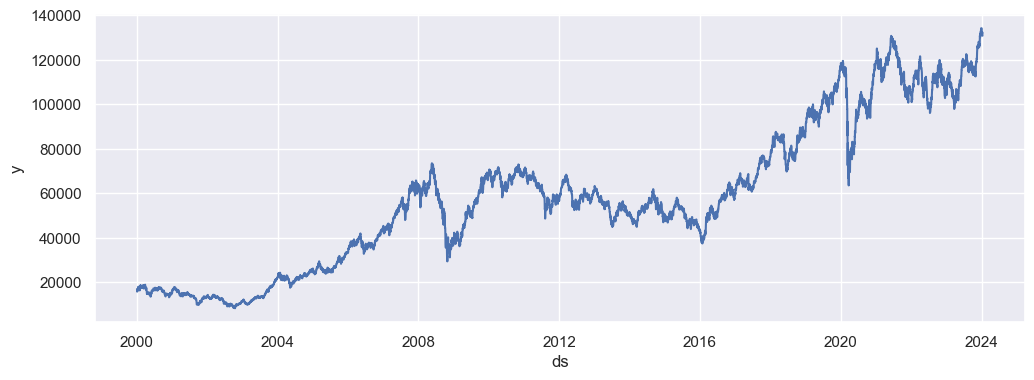

In [6]:
plt.figure(figsize=(12, 4))

sns.lineplot(
    data=df2,
    x='ds',
    y='y'
);

Vamos visualizar agora as janelas históricas que testaremos para treinamento. Avaliaremos a performance dos modelos para janelas:

- Desde o início da série histórica (2000)
- Últimos 15 anos (2008-2023)
- Últimos 10 anos (2013-2023)
- Últimos 5 anos (2018-2023)
- Últimos 3 anos (2021-2023)

<Axes: xlabel='ds', ylabel='y'>

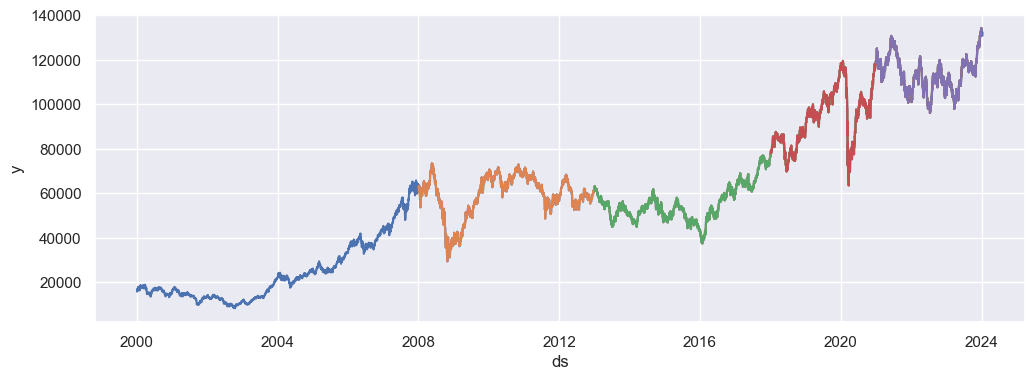

In [7]:
plt.figure(figsize=(12, 4))

sns.lineplot(
    data = df2,
    x='ds',
    y='y'
)
sns.lineplot(
    data = df2.filter(
        (pl.col('ds') > datetime.date(2008, 1, 1)) & (pl.col('ds') < datetime.date(2023, 12, 31))
    ),
    x='ds',
    y='y'
)
sns.lineplot(
    data = df2.filter(
        (pl.col('ds') > datetime.date(2013, 1, 1)) & (pl.col('ds') < datetime.date(2023, 12, 31))
    ),
    x='ds',
    y='y'
)
sns.lineplot(
    data = df2.filter(
        (pl.col('ds') > datetime.date(2018, 1, 1)) & (pl.col('ds') < datetime.date(2023, 12, 31))
    ),
    x='ds',
    y='y'
)
sns.lineplot(
    data = df2.filter(
        (pl.col('ds') > datetime.date(2021, 1, 1)) & (pl.col('ds') < datetime.date(2023, 12, 31))
    ),
    x='ds',
    y='y'
)

## 3. Preparação dos Dados

Vamos separar os períodos de dados e usar os últimos 123 dias para teste.

- Desde o início da série histórica (2000)
- Últimos 15 anos (2008-2023)
- Últimos 10 anos (2013-2023)
- Últimos 5 anos (2018-2023)
- Últimos 3 anos (2021-2023)

In [8]:
def split_train_test(df, start_date):
    df_split = df.filter(pl.col('ds') >= start_date)

    train = df_split[:-183].to_pandas()
    test = df_split[-183:].to_pandas()

    return {'train': train, 'test': test}

In [9]:
dfs_2000 = split_train_test(df2, datetime.date(2000, 1, 1))
dfs_2008 = split_train_test(df2, datetime.date(2008, 1, 1))
dfs_2013 = split_train_test(df2, datetime.date(2013, 1, 1))
dfs_2018 = split_train_test(df2, datetime.date(2018, 1, 1))
dfs_2021 = split_train_test(df2, datetime.date(2021, 1, 1))

dfs = [dfs_2000, dfs_2008, dfs_2013, dfs_2018, dfs_2021]

Vamos visualizar a série de treinamento e teste.

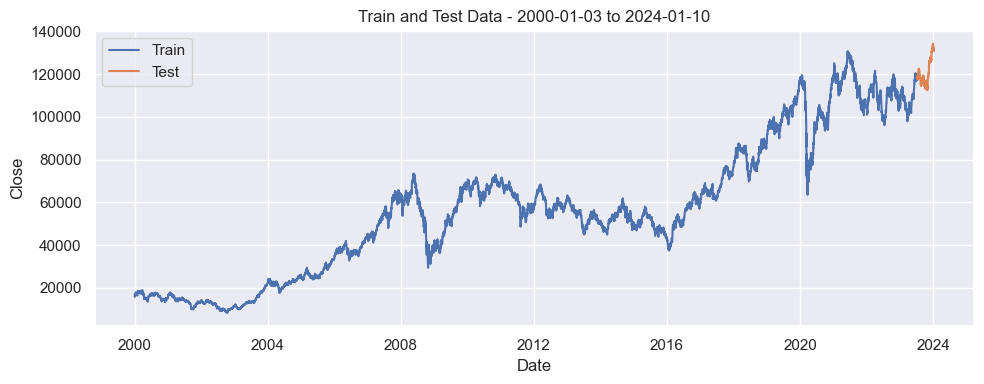

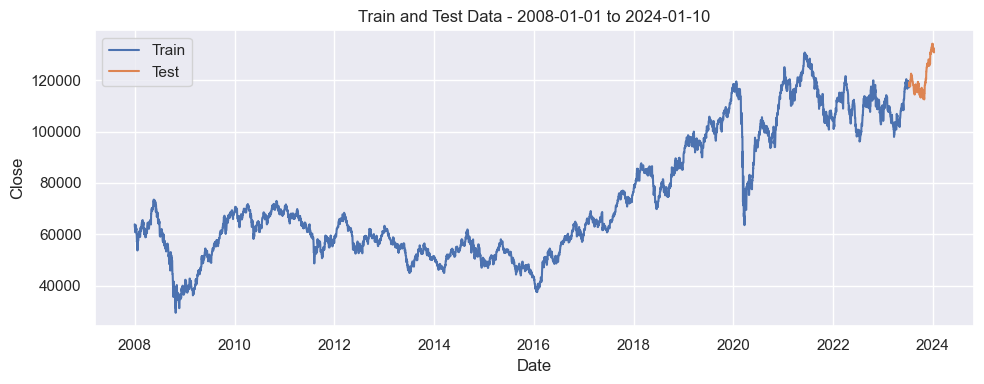

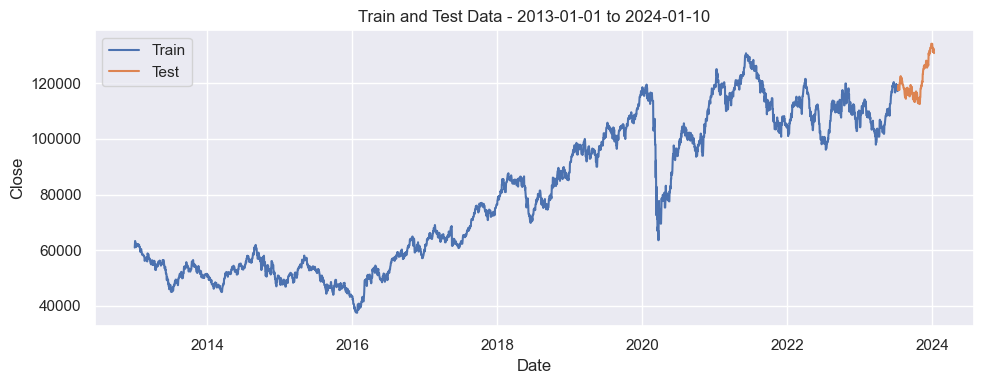

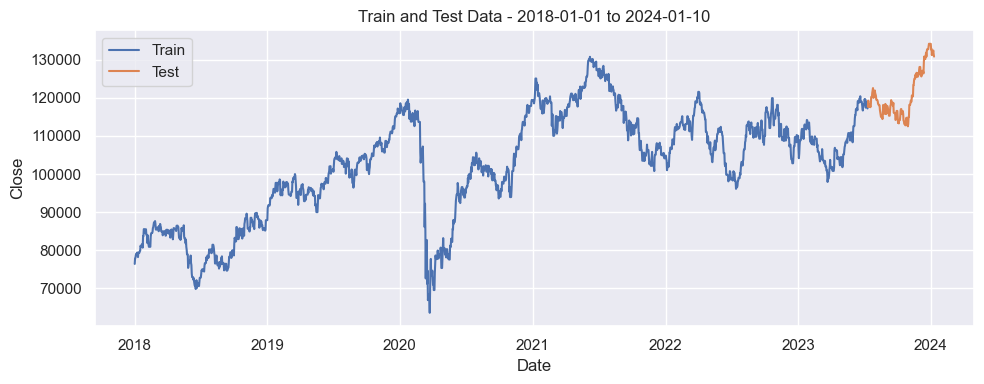

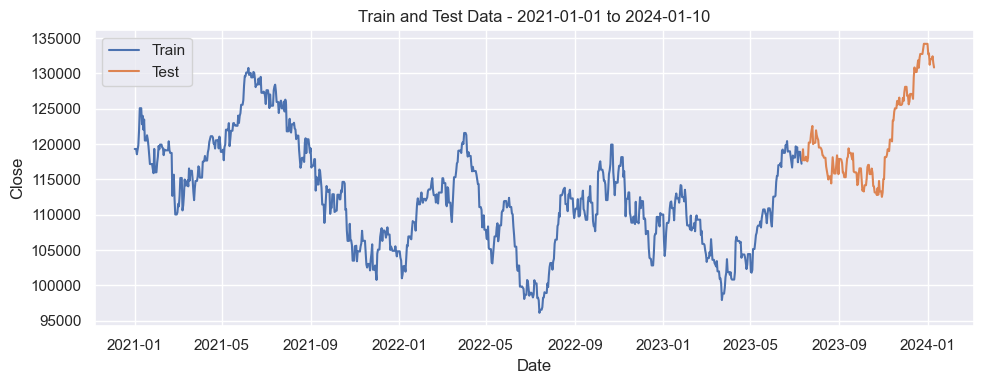

In [10]:
for df in dfs:

    fig = plt.figure(figsize=(10, 4))

    sns.lineplot(
        data=df['train'],x='ds', y='y',
        label='Train'
    )

    sns.lineplot(
        data=df['test'], x='ds', y='y',
        label='Test'
    );

    ax = plt.gca()
    ax.set_title(f'Train and Test Data - {df["train"]["ds"].min().date()} to {df["test"]["ds"].max().date()}')
    ax.set_ylabel('Close')
    ax.set_xlabel('Date')
    fig.tight_layout()

    plt.show()

## 4. Modelagem

Vamos utilizar os seguintes modelos para previsão e comparar com a performance do modelo de baseline (Naive):

- ARIMA
- SARIMA
- XGBoost

Iremos utilizar o erro médio percentual absoluto (MAPE) como métrica de avaliação dos modelos e a técnica de validação por Janela Deslizantes (Sliding Window).

Como os modelos de Série Temporal funcionam de maneira diferentes, não vamos utilizar todos os dataframes para validação. Usaremos, nesses modelos, a maior série histórica (2000-2023) para conseguirmos avaliar o comportamento do modelo na maior variedade de cenários possíveis.

In [11]:
metrics = pd.DataFrame(columns=['Modelo', 'MAE', 'RMSE', 'MAPE']).set_index('Modelo')

In [12]:
def get_sliding_window_index(df_train, window_train = 90, h = 3, plot = False):

    df_shape = df_train.shape[0]
    slide = 0

    train_start = h*slide
    train_end = train_start+window_train

    valid_start = train_end
    valid_end = valid_start+h

    if plot:
        plt.figure(figsize=(50, 20))

    list_index = []
    while valid_end < df_shape:

        if plot:
            plt.barh(f'G{slide}', train_end - train_start, left=train_start, color='blue')
            plt.barh(f'G{slide}', valid_end - valid_start, left=valid_start, color='red')

        list_index.append((train_start, train_end, valid_start, valid_end))

        slide += 1

        train_start = h*slide
        train_end = train_start+window_train
        valid_start = train_end
        valid_end = valid_start+h

    if plot:
        plt.xlim(0, df_train.shape[0])  # Setting limit for x-axis
        plt.tight_layout()
    
    return list_index


In [13]:
def get_expand_window_index(df_train, window_train = 90, h = 3, plot = False):

    df_shape = df_train.shape[0]
    expand = 0

    train_start = 0
    train_end = window_train

    valid_start = train_end
    valid_end = valid_start+h

    if plot:
        plt.figure(figsize=(50, 20))

    list_index = []
    while valid_end < df_shape:

        if plot:
            plt.barh(f'G{expand}', train_end - train_start, left=train_start, color='blue')
            plt.barh(f'G{expand}', valid_end - valid_start, left=valid_start, color='red')

        list_index.append((train_start, train_end, valid_start, valid_end))

        expand += 1

        train_end = train_start+window_train+(h*expand)
        valid_start = train_end
        valid_end = valid_start+h

    if plot:
        plt.xlim(0, df_train.shape[0])  # Setting limit for x-axis
        plt.tight_layout()
    
    return list_index

In [14]:
def print_result(df_result, model = '-'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    sns.lineplot(
        data=df_result, x='ds', y='y', label='Real', ax=ax1
    )

    sns.lineplot(
        data=df_result, x='ds', y='y_pred', label='Predito', ax=ax1
    )

    ax1.set_title('Predição')

    sns.lineplot(
        data=df_result, x='ds', y='diff', label='Erro', ax=ax2
    )

    ax2.set_title('Erro')

    plt.tight_layout()
    plt.show()

    metrics = pd.DataFrame({
        'Modelo': [model],
        'MAE': [df_result['diff'].abs().mean()],
        'RMSE': [np.sqrt((df_result['diff']**2).mean())],
        'MAPE': [np.abs(df_result['diff'] / df_result['y']).mean()]
    }).set_index('Modelo')

    return metrics

### 4.1. Baseline

Como baseline, vamos utilizar o modelo Naive que consiste em utilizar uma média móvel de 7 dias para prever os próximos 3 dias.

In [15]:
def cross_val_baseline(df_train, h = 3, window_train = 90, params = {'window_size': 7}):

    print(f'Iniciando validação cruzada da Baseline - df {df["train"]["ds"].min().year}')

    df_train_baseline = df_train.copy()
    df_train_baseline['unique_id'] = 1

    model_baseline = StatsForecast(
        models=[WindowAverage(window_size=params['window_size'])],
        freq='D',
        n_jobs=-1
    )

    indexes = get_sliding_window_index(df_train_baseline, window_train = window_train, h = h, plot = False)
    df_pred = pd.DataFrame(columns=['ds', 'y_pred'])

    for index in tqdm(indexes):
        df_train = df_train_baseline[index[0]:index[1]]

        model_baseline.fit(df_train)
        predict = model_baseline.predict(h=h)

        predict.rename(columns={'WindowAverage': 'y_pred'}, inplace=True)
        if df_pred.shape[0] == 0:
            df_pred = predict.reset_index()[['ds', 'y_pred']]
        else:
            df_pred = pd.concat([df_pred, predict.reset_index()[['ds', 'y_pred']]], axis=0)

    result = df_pred.merge(df_train_baseline, on=['ds'], how='right')
    result['diff'] = result['y'] - result['y_pred']

    return result

Iniciando validação cruzada da Baseline - df 2021


  0%|          | 0/2833 [00:00<?, ?it/s]

100%|██████████| 2833/2833 [00:09<00:00, 291.39it/s]


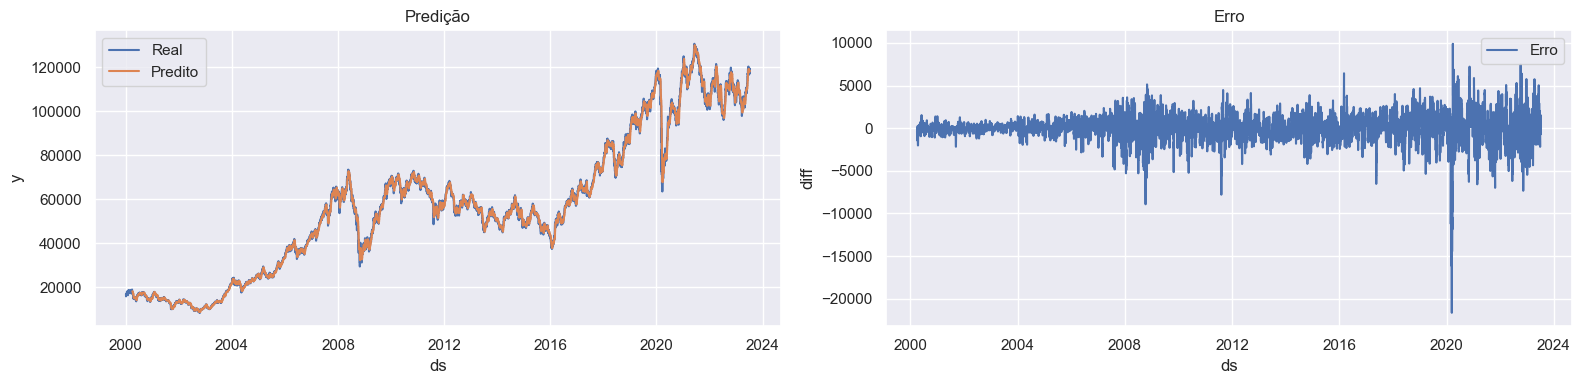

/var/folders/6x/3y02z1591rj130ytmr_hv8nh0000gn/T/ipykernel_53556/2714453325.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics = pd.concat([metrics, result_metrics], axis=0)


,MAE,RMSE,MAPE
Modelo,,,
Baseline - 2000,1060.231798,1553.589418,0.020311


In [16]:
result = cross_val_baseline(dfs[0]['train'], h = 3, window_train = 90, params = {'window_size': 7})
result_metrics = print_result(result, model = f'Baseline - {dfs[0]["train"]["ds"].min().year}')

metrics = pd.concat([metrics, result_metrics], axis=0)
metrics

### 4.2. SARIMA

Vamos utilizar o modelo SARIMA para previsão dos próximos 3 dias com base nos últimos 90 dias.

In [17]:
def cross_val_sarima(df_train, h = 3, window_train = 90, params = {'seasonal': False, 'exg': False}):

    print(f'Iniciando validação cruzada do ARIMA/SARIMA - df {df["train"]["ds"].min().year}')

    df_train_arima = df_train.copy()

    indexes = get_sliding_window_index(df_train_arima, window_train = window_train, h = h, plot = False)
    df_pred = pd.DataFrame(columns=['ds', 'y_pred'])

    for index in tqdm(indexes):
        df_train = df_train_arima[index[0]:index[1]]

        model_arima = auto_arima(
            df_train['y'],
            exogenous = df_train[params['exg']] if params['exg'] else None,
            seasonal=params['seasonal'],
            trace=False,
            error_action='ignore',
            suppress_warnings=True,
        )
        predict = model_arima.predict(n_periods=h)
        
        predict_temp = pd.DataFrame(predict, columns=['y_pred'])
        predict_temp['ds'] = df_train_arima[index[2]:index[3]]['ds']

        if df_pred.shape[0] == 0:
            df_pred = predict_temp[['ds', 'y_pred']]
        else:
            df_pred = pd.concat([df_pred, predict_temp[['ds', 'y_pred']]], axis=0)

    result = df_pred.merge(df_train_arima, on=['ds'], how='right')
    result['diff'] = result['y'] - result['y_pred']

    return result

In [18]:
def grid_search_sarima(df_train, params = {'window_train': [15, 30, 60, 90, 120], 'seasonal': [False, True], 'exg': [False]}):

    df = df_train.copy()

    metrics = pd.DataFrame(columns=['N Search', 'MAE', 'RMSE', 'MAPE']).set_index('N Search')
    infos = []
    n_search = 0
    
    for window_train in params['window_train']:
        for seasonal in params['seasonal']:
            for exg in params['exg']:

                print(f'\n[ N Search {n_search} ]\nwindow_train: {window_train}, seasonal: {seasonal}, exg: {exg}')

                indexes = get_sliding_window_index(df, window_train = window_train, h = 3, plot = False)
                cross_mae = []
                cross_rmse = []
                cross_mape = []

                df_pred = pd.DataFrame(columns=['ds', 'y_pred'])
                for index in tqdm(indexes):
                    df_train = df[index[0]:index[1]].copy()
                    df_test = df[index[2]:index[3]].copy()

                    model_arima = auto_arima(
                        df_train['y'],
                        exogenous = df_train[exg] if exg else None,
                        seasonal=seasonal,
                        trace=False,
                        error_action='ignore',
                        suppress_warnings=True,
                    )
                    predict = model_arima.predict(n_periods=3)
                    
                    predict_temp = pd.DataFrame(predict, columns=['y_pred'])
                    predict_temp['ds'] = df_test['ds']

                    if df_pred.shape[0] == 0:
                        df_pred = predict_temp[['ds', 'y_pred']]
                    else:
                        df_pred = pd.concat([df_pred, predict_temp[['ds', 'y_pred']]], axis=0)

                    result = df_pred.merge(df, on=['ds'], how='right')
                    result['diff'] = result['y'] - result['y_pred']

                    # Calculando métricas
                    mae = result['diff'].abs().mean()
                    rmse = np.sqrt((result['diff']**2).mean())
                    mape = np.abs(result['diff'] / result['y']).mean()

                    #adicionando aos resultados da validação cruzada
                    cross_mae.append(mae)
                    cross_rmse.append(rmse)
                    cross_mape.append(mape)

                # Salvando resultados da iteração do grid search
                infos.append({
                    'N Search': n_search,
                    'window_train': window_train,
                    'seasonal': seasonal,
                    'exg': exg,
                    'MAE': np.mean(cross_mae),
                    'RMSE': np.mean(cross_rmse),
                    'MAPE': np.mean(cross_mape)
                })

                print(f"MAE: {np.mean(cross_mae)} / RMSE: {np.mean(cross_rmse)} / MAPE: {np.mean(cross_mape)}")
                
                # Incrementando o número de buscas
                n_search += 1
                
    return infos

Vamos procurar a janela de teste com menor erro de previsão.

In [75]:
grid_search_sarima(dfs[0]['train'], params = {'window_train': [15, 45, 90, 180, 365], 'seasonal': [True], 'exg': [False]})


[ N Search 0 ]
window_train: 15, seasonal: True, exg: False


100%|██████████| 2858/2858 [07:57<00:00,  5.98it/s]


MAE: 548.3102671855539 / RMSE: 841.5159232881385 / MAPE: 0.018342449543414255

[ N Search 1 ]
window_train: 45, seasonal: True, exg: False


100%|██████████| 2848/2848 [23:54<00:00,  1.99it/s]    


MAE: 479.7425898979902 / RMSE: 773.8948828986062 / MAPE: 0.016001001850365324

[ N Search 2 ]
window_train: 90, seasonal: True, exg: False


100%|██████████| 2833/2833 [7:37:41<00:00,  9.69s/it]      


MAE: 474.85975198331954 / RMSE: 778.6986423476676 / MAPE: 0.015606203966801603

[ N Search 3 ]
window_train: 180, seasonal: True, exg: False


100%|██████████| 2803/2803 [1:25:51<00:00,  1.84s/it]    


MAE: 455.55215405921183 / RMSE: 755.5445240925794 / MAPE: 0.014575511928545393

[ N Search 4 ]
window_train: 365, seasonal: True, exg: False


100%|██████████| 2741/2741 [1:14:34<00:00,  1.63s/it]    

MAE: 476.6416299100357 / RMSE: 769.2871882038103 / MAPE: 0.015065559154721544


[{'N Search': 0,
  'window_train': 15,
  'seasonal': True,
  'exg': False,
  'MAE': 548.3102671855539,
  'RMSE': 841.5159232881385,
  'MAPE': 0.018342449543414255},
 {'N Search': 1,
  'window_train': 45,
  'seasonal': True,
  'exg': False,
  'MAE': 479.7425898979902,
  'RMSE': 773.8948828986062,
  'MAPE': 0.016001001850365324},
 {'N Search': 2,
  'window_train': 90,
  'seasonal': True,
  'exg': False,
  'MAE': 474.85975198331954,
  'RMSE': 778.6986423476676,
  'MAPE': 0.015606203966801603},
 {'N Search': 3,
  'window_train': 180,
  'seasonal': True,
  'exg': False,
  'MAE': 455.55215405921183,
  'RMSE': 755.5445240925794,
  'MAPE': 0.014575511928545393},
 {'N Search': 4,
  'window_train': 365,
  'seasonal': True,
  'exg': False,
  'MAE': 476.6416299100357,
  'RMSE': 769.2871882038103,
  'MAPE': 0.015065559154721544}]

O período de treinamento com menor erro foi com os últimos 180 dias. Vamos utilizar esse período para treinar o modelo e prever os próximos 3 dias.

In [19]:
result = cross_val_sarima(dfs[0]['train'], h = 3, window_train = 180)
result_metrics = print_result(result, model = f'ARIMA - {dfs[0]["train"]["ds"].min().year}')

metrics = pd.concat([metrics, result_metrics], axis=0)
metrics

Iniciando validação cruzada do ARIMA/SARIMA - df 2021


  9%|▉         | 255/2803 [01:24<14:03,  3.02it/s]  


KeyboardInterrupt: 

Testando com padrão Sasonal e Variável Exógena.

Iniciando validação cruzada do ARIMA/SARIMA - df 2021


100%|██████████| 2829/2829 [10:34<00:00,  4.46it/s]


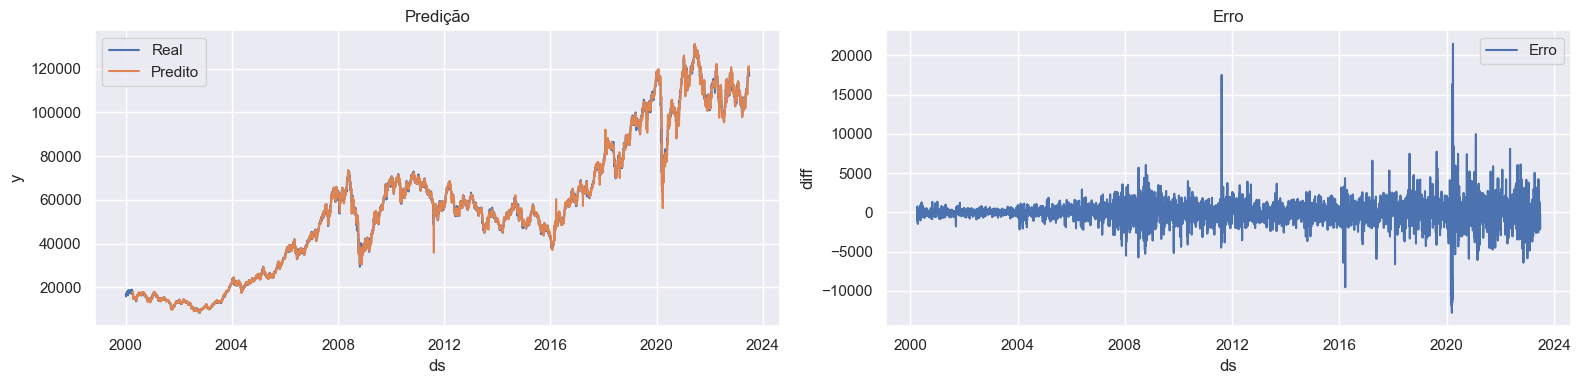

,MAE,RMSE,MAPE
Modelo,,,
Baseline - 2000,1060.649656,1554.235349,0.020330
ARIMA - 2000,751.279120,1295.718727,0.014118
SARIMAX - 2000,750.949705,1294.167984,0.014110


In [21]:
df_sarimax = dfs[0]['train'].copy()

df_sarimax['weekday'] = df_sarimax['ds'].dt.weekday
df_sarimax['weekend'] = df_sarimax['weekday'].apply(lambda x: 1 if x >= 5 else 0)
df_sarimax['month'] = df_sarimax['ds'].dt.month

result = cross_val_sarima(df_sarimax, h = 3, window_train = 180, params={'seasonal': True, 'exg': ['weekday', 'month', 'weekend']})
result_metrics = print_result(result, model = f'SARIMAX - {df_sarimax["ds"].min().year}')

metrics = pd.concat([metrics, result_metrics], axis=0)
metrics

### 4.3. XGBoost

Vamos utilizar o modelo XGBoost para previsão dos próximos 3 dias com base nas informações dos últimos 60 dias.

Por se tratar de um modelo supervisionado precisaremos formatar as variáveis como entrada e saída (ABT) sendo que a saída será o fechamento da IBOVESPA nos dias seguinte e as entradas serão relacionadas aos dias anteriores.

Precisaremos treinar um modelo para cada dia de previsão.

In [23]:
def create_abt(df, col_ds = 'ds', col_y = 'y', periods_stats = [7, 14, 28, 60], before_days = 7, n_prev = 1):
    abt = df.copy()
    abt.rename(columns={col_y: 'close'}, inplace=True)

    abt['year'] = abt[col_ds].dt.year
    abt['month'] = abt[col_ds].dt.month
    abt['day'] = abt[col_ds].dt.day

    for shift in range(1, before_days+1):
        abt[f'd{shift}_close'] = abt['close'].shift(shift)

    for period in periods_stats:
        abt[f'd{period}_mean'] = abt['close'].rolling(period).mean()
        abt[f'd{period}_min'] = abt['close'].rolling(period).min()
        abt[f'd{period}_max'] = abt['close'].rolling(period).max()

    abt['next_close'] = abt['close'].shift(-n_prev)

    abt.drop(columns=['ds'], inplace=True)

    return abt.dropna()


In [24]:
def abt_to_result(abt, pred, n_prev = 1):

    abt_test = abt.copy()
    abt_test['y_pred'] = pred

    result = pd.DataFrame({
    'ds': pd.to_datetime(
        abt_test['year'].astype(str) + '-' + abt_test['month'].astype(str) + '-' + abt_test['day'].astype(str)),
    'y': abt_test['close']
    })

    result['y_pred'] = abt_test['y_pred'].shift(n_prev)
    result['diff'] = result['y'] - result['y_pred']

    return result

In [25]:
def grid_search_xgb(abt_train, params = {'n_estimators': [100], 'max_depth': [3], 'learning_rate': [0.01]}):

    df = abt_train.copy()

    metrics = pd.DataFrame(columns=['N Search', 'MAE', 'RMSE', 'MAPE']).set_index('N Search')
    infos = []
    n_search = 0
    
    for n_estimators in params['n_estimators']:
        for max_depth in params['max_depth']:
            for learning_rate in params['learning_rate']:

                print(f'\n[ N Search {n_search} ]\nn_estimators: {n_estimators}, max_depth: {max_depth}, learning_rate: {learning_rate}')

                indexes = get_expand_window_index(df, window_train = 183, h = 183, plot = False)
                cross_mae = []
                cross_rmse = []
                cross_mape = []

                for index in tqdm(indexes):
                    df_train = df[index[0]:index[1]].copy()
                    df_test = df[index[2]:index[3]].copy()

                    X_train_temp = df_train.drop(columns=['next_close'])
                    y_train_temp = df_train['next_close']

                    X_test_temp = df_test.drop(columns=['next_close'])

                    # Treinando Modelo
                    model_xgb = xgb.XGBRegressor(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        n_jobs=-1
                    )

                    # Calculando previsão
                    model_xgb.fit(X_train_temp, y_train_temp)
                    pred = model_xgb.predict(X_test_temp)

                    # Salvando predições no formato do Dataframe de resultados
                    result = abt_to_result(df_test, pred)

                    # Calculando métricas
                    mae = result['diff'].abs().mean()
                    rmse = np.sqrt((result['diff']**2).mean())
                    mape = np.abs(result['diff'] / result['y']).mean()

                    #adicionando aos resultados da validação cruzada
                    cross_mae.append(mae)
                    cross_rmse.append(rmse)
                    cross_mape.append(mape)

                # Salvando resultados da iteração do grid search
                infos.append({
                    'N Search': n_search,
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'learning_rate': learning_rate,
                    'MAE': np.mean(cross_mae),
                    'RMSE': np.mean(rmse),
                    'MAPE': np.mean(mape)
                })

                print(f"MAE: {np.mean(cross_mae)} / RMSE: {np.mean(cross_rmse)} / MAPE: {np.mean(cross_mape)}")
                
                # Incrementando o número de buscas
                n_search += 1
 
    return infos

In [28]:
def train_xgbs(train = None, test = None, h = 1, params_grid = None):

    best_results = []

    for h in range(1, h+1):
        print(f'Treinando modelo para Horizonte: {h}')

        abt_train = create_abt(train, n_prev=h)

        return_infos = grid_search_xgb(abt_train, params = params_grid)
        df_infos = pd.DataFrame(return_infos).set_index('N Search')        

        print(f"BEST PARAMS - Horizonte: {h}\n")
        n = df_infos.idxmin()['MAPE']
        print(df_infos.iloc[int(n)])
        best_results.append(df_infos.iloc[int(n)])
        print('\n\n')

    return best_results

In [89]:
params = {
    'n_estimators': [100, 200, 300, 500, 700],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.001, 0.01, 0.05, 0.1]
}

results = train_xgbs(train = dfs[0]['train'], h = 3, params_grid = params)

Treinando modelo para Horizonte: 1

[ N Search 0 ]
n_estimators: 100, max_depth: 3, learning_rate: 0.001


  0%|          | 0/45 [00:00<?, ?it/s]

100%|██████████| 45/45 [00:03<00:00, 12.87it/s]


MAE: 23098.569991390985 / RMSE: 23426.69699076975 / MAPE: 0.3573726735725299

[ N Search 1 ]
n_estimators: 100, max_depth: 3, learning_rate: 0.01


100%|██████████| 45/45 [00:03<00:00, 13.74it/s]


MAE: 10581.880785924144 / RMSE: 10870.595794680778 / MAPE: 0.1647309958932425

[ N Search 2 ]
n_estimators: 100, max_depth: 3, learning_rate: 0.05


100%|██████████| 45/45 [00:03<00:00, 14.00it/s]


MAE: 1664.1115478813715 / RMSE: 2121.2935637371033 / MAPE: 0.031367701927943

[ N Search 3 ]
n_estimators: 100, max_depth: 3, learning_rate: 0.1


100%|██████████| 45/45 [00:03<00:00, 13.84it/s]


MAE: 1655.9769383394382 / RMSE: 2127.497134403355 / MAPE: 0.03182432817371375

[ N Search 4 ]
n_estimators: 100, max_depth: 5, learning_rate: 0.001


100%|██████████| 45/45 [00:04<00:00,  9.23it/s]


MAE: 23010.11936670101 / RMSE: 23336.544682259548 / MAPE: 0.3563467368934293

[ N Search 5 ]
n_estimators: 100, max_depth: 5, learning_rate: 0.01


100%|██████████| 45/45 [00:05<00:00,  8.96it/s]


MAE: 10158.678800366299 / RMSE: 10431.16295730146 / MAPE: 0.1598931479222162

[ N Search 6 ]
n_estimators: 100, max_depth: 5, learning_rate: 0.05


100%|██████████| 45/45 [00:05<00:00,  8.26it/s]


MAE: 1747.6691520718864 / RMSE: 2219.0956827557425 / MAPE: 0.03343125031514228

[ N Search 7 ]
n_estimators: 100, max_depth: 5, learning_rate: 0.1


100%|██████████| 45/45 [00:06<00:00,  6.79it/s]


MAE: 1721.7575827276028 / RMSE: 2199.6881397697634 / MAPE: 0.03304972527520663

[ N Search 8 ]
n_estimators: 100, max_depth: 7, learning_rate: 0.001


100%|██████████| 45/45 [00:07<00:00,  6.09it/s]


MAE: 23009.8900514633 / RMSE: 23336.46599890015 / MAPE: 0.35633918844151646

[ N Search 9 ]
n_estimators: 100, max_depth: 7, learning_rate: 0.01


100%|██████████| 45/45 [00:07<00:00,  6.10it/s]


MAE: 10163.879954951735 / RMSE: 10437.14604145004 / MAPE: 0.16000267916191915

[ N Search 10 ]
n_estimators: 100, max_depth: 7, learning_rate: 0.05


100%|██████████| 45/45 [00:08<00:00,  5.39it/s]


MAE: 1809.4332614325783 / RMSE: 2286.958891507721 / MAPE: 0.03483094520219134

[ N Search 11 ]
n_estimators: 100, max_depth: 7, learning_rate: 0.1


100%|██████████| 45/45 [00:08<00:00,  5.16it/s]


MAE: 1743.9603639632942 / RMSE: 2222.765059839741 / MAPE: 0.03359515303887514

[ N Search 12 ]
n_estimators: 200, max_depth: 3, learning_rate: 0.001


100%|██████████| 45/45 [00:05<00:00,  7.99it/s]


MAE: 21142.302467400223 / RMSE: 21458.989161149115 / MAPE: 0.3271648142558361

[ N Search 13 ]
n_estimators: 200, max_depth: 3, learning_rate: 0.01


100%|██████████| 45/45 [00:06<00:00,  6.48it/s]


MAE: 4837.302665335965 / RMSE: 5174.619970583149 / MAPE: 0.07731640044768169

[ N Search 14 ]
n_estimators: 200, max_depth: 3, learning_rate: 0.05


100%|██████████| 45/45 [00:08<00:00,  5.45it/s]


MAE: 1655.902271014576 / RMSE: 2126.819312700751 / MAPE: 0.03181706456539013

[ N Search 15 ]
n_estimators: 200, max_depth: 3, learning_rate: 0.1


100%|██████████| 45/45 [00:06<00:00,  7.21it/s]


MAE: 1760.7833810286934 / RMSE: 2237.369305475966 / MAPE: 0.03358926128087979

[ N Search 16 ]
n_estimators: 200, max_depth: 5, learning_rate: 0.001


100%|██████████| 45/45 [00:09<00:00,  4.67it/s]


MAE: 20971.517399863587 / RMSE: 21284.558127686985 / MAPE: 0.3251792321971326

[ N Search 17 ]
n_estimators: 200, max_depth: 5, learning_rate: 0.01


100%|██████████| 45/45 [00:09<00:00,  4.60it/s]


MAE: 4508.122548458486 / RMSE: 4834.315813916433 / MAPE: 0.07395351983035711

[ N Search 18 ]
n_estimators: 200, max_depth: 5, learning_rate: 0.05


100%|██████████| 45/45 [00:12<00:00,  3.55it/s]


MAE: 1715.9285170558608 / RMSE: 2192.3681397777323 / MAPE: 0.03306618581633277

[ N Search 19 ]
n_estimators: 200, max_depth: 5, learning_rate: 0.1


100%|██████████| 45/45 [00:10<00:00,  4.39it/s]


MAE: 1789.276129068414 / RMSE: 2268.4573607097786 / MAPE: 0.03406125008127385

[ N Search 20 ]
n_estimators: 200, max_depth: 7, learning_rate: 0.001


100%|██████████| 45/45 [00:14<00:00,  3.00it/s]


MAE: 20971.26824848329 / RMSE: 21284.545773867514 / MAPE: 0.32517586113281866

[ N Search 21 ]
n_estimators: 200, max_depth: 7, learning_rate: 0.01


100%|██████████| 45/45 [00:15<00:00,  2.90it/s]


MAE: 4521.783734570551 / RMSE: 4848.105289691552 / MAPE: 0.07441330396369558

[ N Search 22 ]
n_estimators: 200, max_depth: 7, learning_rate: 0.05


100%|██████████| 45/45 [00:17<00:00,  2.59it/s]


MAE: 1761.0718300471228 / RMSE: 2241.671945084899 / MAPE: 0.034110427339497894

[ N Search 23 ]
n_estimators: 200, max_depth: 7, learning_rate: 0.1


100%|██████████| 45/45 [00:17<00:00,  2.59it/s]


MAE: 1785.2799544747786 / RMSE: 2261.3449390169394 / MAPE: 0.03417385225526431

[ N Search 24 ]
n_estimators: 300, max_depth: 3, learning_rate: 0.001


100%|██████████| 45/45 [00:09<00:00,  4.63it/s]


MAE: 19367.13115162832 / RMSE: 19674.008406622303 / MAPE: 0.2997761365997462

[ N Search 25 ]
n_estimators: 300, max_depth: 3, learning_rate: 0.01


100%|██████████| 45/45 [00:09<00:00,  4.78it/s]


MAE: 2633.6151495964973 / RMSE: 3041.465881140068 / MAPE: 0.04460055570146529

[ N Search 26 ]
n_estimators: 300, max_depth: 3, learning_rate: 0.05


100%|██████████| 45/45 [00:09<00:00,  4.81it/s]


MAE: 1734.6254607371789 / RMSE: 2207.484086711417 / MAPE: 0.03310088659486109

[ N Search 27 ]
n_estimators: 300, max_depth: 3, learning_rate: 0.1


100%|██████████| 45/45 [00:08<00:00,  5.17it/s]


MAE: 1805.2539519183072 / RMSE: 2285.2417952611713 / MAPE: 0.034365396215726034

[ N Search 28 ]
n_estimators: 300, max_depth: 5, learning_rate: 0.001


100%|██████████| 45/45 [00:14<00:00,  3.04it/s]


MAE: 19122.99710334154 / RMSE: 19424.871035400924 / MAPE: 0.2968809774438988

[ N Search 29 ]
n_estimators: 300, max_depth: 5, learning_rate: 0.01


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


MAE: 2520.695298668346 / RMSE: 2927.9118215035815 / MAPE: 0.04458125650590997

[ N Search 30 ]
n_estimators: 300, max_depth: 5, learning_rate: 0.05


100%|██████████| 45/45 [00:15<00:00,  2.99it/s]


MAE: 1761.6533032614084 / RMSE: 2237.8751122560316 / MAPE: 0.03371082427853075

[ N Search 31 ]
n_estimators: 300, max_depth: 5, learning_rate: 0.1


100%|██████████| 45/45 [00:13<00:00,  3.32it/s]


MAE: 1820.6578710460544 / RMSE: 2300.4546833195877 / MAPE: 0.034556971519723

[ N Search 32 ]
n_estimators: 300, max_depth: 7, learning_rate: 0.001


100%|██████████| 45/45 [00:18<00:00,  2.49it/s]


MAE: 19124.38537469475 / RMSE: 19426.4096416594 / MAPE: 0.29689900433422545

[ N Search 33 ]
n_estimators: 300, max_depth: 7, learning_rate: 0.01


100%|██████████| 45/45 [00:22<00:00,  1.98it/s]


MAE: 2554.0438205891332 / RMSE: 2964.74854426086 / MAPE: 0.04541528385085698

[ N Search 34 ]
n_estimators: 300, max_depth: 7, learning_rate: 0.05


100%|██████████| 45/45 [00:22<00:00,  2.02it/s]


MAE: 1789.3942007211538 / RMSE: 2270.0957546952122 / MAPE: 0.0344886201719206

[ N Search 35 ]
n_estimators: 300, max_depth: 7, learning_rate: 0.1


100%|██████████| 45/45 [00:21<00:00,  2.05it/s]


MAE: 1803.0496662517169 / RMSE: 2280.247739610483 / MAPE: 0.03441451847521576

[ N Search 36 ]
n_estimators: 500, max_depth: 3, learning_rate: 0.001


100%|██████████| 45/45 [00:15<00:00,  2.92it/s]


MAE: 16284.990278612444 / RMSE: 16578.413648962058 / MAPE: 0.2522486053130081

[ N Search 37 ]
n_estimators: 500, max_depth: 3, learning_rate: 0.01


100%|██████████| 45/45 [00:16<00:00,  2.76it/s]


MAE: 1673.9020482772437 / RMSE: 2130.7810618670314 / MAPE: 0.031479356201567193

[ N Search 38 ]
n_estimators: 500, max_depth: 3, learning_rate: 0.05


100%|██████████| 45/45 [00:14<00:00,  3.03it/s]


MAE: 1794.7868856837608 / RMSE: 2269.373754172237 / MAPE: 0.03410229183425337

[ N Search 39 ]
n_estimators: 500, max_depth: 3, learning_rate: 0.1


100%|██████████| 45/45 [00:15<00:00,  2.97it/s]


MAE: 1862.0389176253434 / RMSE: 2344.520480875973 / MAPE: 0.03533842067970348

[ N Search 40 ]
n_estimators: 500, max_depth: 5, learning_rate: 0.001


100%|██████████| 45/45 [00:25<00:00,  1.80it/s]


MAE: 15924.276972799335 / RMSE: 16210.170440923066 / MAPE: 0.24795596243442547

[ N Search 41 ]
n_estimators: 500, max_depth: 5, learning_rate: 0.01


100%|██████████| 45/45 [00:26<00:00,  1.71it/s]


MAE: 1756.5887665502898 / RMSE: 2225.5471729609444 / MAPE: 0.03362385403894237

[ N Search 42 ]
n_estimators: 500, max_depth: 5, learning_rate: 0.05


100%|██████████| 45/45 [00:25<00:00,  1.74it/s]


MAE: 1795.5230090764267 / RMSE: 2273.4550227434693 / MAPE: 0.03424432801935451

[ N Search 43 ]
n_estimators: 500, max_depth: 5, learning_rate: 0.1


100%|██████████| 45/45 [00:25<00:00,  1.79it/s]


MAE: 1844.7800541580814 / RMSE: 2325.218121428246 / MAPE: 0.034928235695668525

[ N Search 44 ]
n_estimators: 500, max_depth: 7, learning_rate: 0.001


100%|██████████| 45/45 [00:32<00:00,  1.37it/s]


MAE: 15932.811918355083 / RMSE: 16218.601787067644 / MAPE: 0.2480548037301675

[ N Search 45 ]
n_estimators: 500, max_depth: 7, learning_rate: 0.01


100%|██████████| 45/45 [00:42<00:00,  1.05it/s]


MAE: 1825.4077958066243 / RMSE: 2305.3786717901176 / MAPE: 0.03493102835189695

[ N Search 46 ]
n_estimators: 500, max_depth: 7, learning_rate: 0.05


100%|██████████| 45/45 [00:40<00:00,  1.11it/s]


MAE: 1813.162743842529 / RMSE: 2295.019897515816 / MAPE: 0.03481403740952746

[ N Search 47 ]
n_estimators: 500, max_depth: 7, learning_rate: 0.1


100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


MAE: 1818.6538533081505 / RMSE: 2296.3831024837336 / MAPE: 0.03464409026485677

[ N Search 48 ]
n_estimators: 700, max_depth: 3, learning_rate: 0.001


100%|██████████| 45/45 [00:18<00:00,  2.40it/s]


MAE: 13704.147020590086 / RMSE: 13991.483342717578 / MAPE: 0.212572378054924

[ N Search 49 ]
n_estimators: 700, max_depth: 3, learning_rate: 0.01


100%|██████████| 45/45 [00:18<00:00,  2.38it/s]


MAE: 1610.9162128453147 / RMSE: 2076.401790973291 / MAPE: 0.0308267437776335

[ N Search 50 ]
n_estimators: 700, max_depth: 3, learning_rate: 0.05


100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


MAE: 1830.462710575015 / RMSE: 2306.8506377849667 / MAPE: 0.03472741216786125

[ N Search 51 ]
n_estimators: 700, max_depth: 3, learning_rate: 0.1


100%|██████████| 45/45 [00:18<00:00,  2.45it/s]


MAE: 1893.1371607667509 / RMSE: 2377.2187959120515 / MAPE: 0.03583417618652822

[ N Search 52 ]
n_estimators: 700, max_depth: 5, learning_rate: 0.001


100%|██████████| 45/45 [00:31<00:00,  1.42it/s]


MAE: 13294.85453105922 / RMSE: 13570.921966006865 / MAPE: 0.20778245909939025

[ N Search 53 ]
n_estimators: 700, max_depth: 5, learning_rate: 0.01


100%|██████████| 45/45 [00:33<00:00,  1.33it/s]


MAE: 1693.0044960031287 / RMSE: 2165.9143942488413 / MAPE: 0.03272483829281667

[ N Search 54 ]
n_estimators: 700, max_depth: 5, learning_rate: 0.05


100%|██████████| 45/45 [00:34<00:00,  1.30it/s]


MAE: 1823.3932227277935 / RMSE: 2299.650088534472 / MAPE: 0.03469338044894328

[ N Search 55 ]
n_estimators: 700, max_depth: 5, learning_rate: 0.1


100%|██████████| 45/45 [00:35<00:00,  1.25it/s]


MAE: 1865.314697802198 / RMSE: 2346.1029418810253 / MAPE: 0.0352380200260942

[ N Search 56 ]
n_estimators: 700, max_depth: 7, learning_rate: 0.001


100%|██████████| 45/45 [00:50<00:00,  1.13s/it]


MAE: 13300.733341560783 / RMSE: 13576.934706922124 / MAPE: 0.20787918700690997

[ N Search 57 ]
n_estimators: 700, max_depth: 7, learning_rate: 0.01


100%|██████████| 45/45 [01:01<00:00,  1.36s/it]


MAE: 1766.3579391311816 / RMSE: 2249.0984622806927 / MAPE: 0.0340581298101927

[ N Search 58 ]
n_estimators: 700, max_depth: 7, learning_rate: 0.05


100%|██████████| 45/45 [01:00<00:00,  1.35s/it]


MAE: 1827.0876573946887 / RMSE: 2309.774944590062 / MAPE: 0.03500382612304231

[ N Search 59 ]
n_estimators: 700, max_depth: 7, learning_rate: 0.1


100%|██████████| 45/45 [01:00<00:00,  1.34s/it]


MAE: 1826.9877504006413 / RMSE: 2305.413311928887 / MAPE: 0.034761473784739164
BEST PARAMS - Horizonte: 1

n_estimators      500.000000
max_depth           3.000000
learning_rate       0.010000
MAE              1673.902048
RMSE             1415.423228
MAPE                0.009325
Name: 37, dtype: float64



Treinando modelo para Horizonte: 2

[ N Search 0 ]
n_estimators: 100, max_depth: 3, learning_rate: 0.001


100%|██████████| 45/45 [00:03<00:00, 12.78it/s]


MAE: 23090.555264375384 / RMSE: 23420.10886330314 / MAPE: 0.3572482630217882

[ N Search 1 ]
n_estimators: 100, max_depth: 3, learning_rate: 0.01


100%|██████████| 45/45 [00:03<00:00, 12.43it/s]


MAE: 10585.391719846994 / RMSE: 10880.951447282947 / MAPE: 0.16527189091221994

[ N Search 2 ]
n_estimators: 100, max_depth: 3, learning_rate: 0.05


100%|██████████| 45/45 [00:03<00:00, 11.92it/s]


MAE: 1797.0276808369586 / RMSE: 2261.348901785597 / MAPE: 0.03493144821397195

[ N Search 3 ]
n_estimators: 100, max_depth: 3, learning_rate: 0.1


100%|██████████| 45/45 [00:03<00:00, 11.84it/s]


MAE: 1787.8016479939329 / RMSE: 2263.1779862756703 / MAPE: 0.035289974764910415

[ N Search 4 ]
n_estimators: 100, max_depth: 5, learning_rate: 0.001


100%|██████████| 45/45 [00:05<00:00,  7.95it/s]


MAE: 23004.36928728823 / RMSE: 23331.402334251932 / MAPE: 0.3563121025519122

[ N Search 5 ]
n_estimators: 100, max_depth: 5, learning_rate: 0.01


100%|██████████| 45/45 [00:06<00:00,  7.22it/s]


MAE: 10184.055342238056 / RMSE: 10467.326893331634 / MAPE: 0.1610124775790854

[ N Search 6 ]
n_estimators: 100, max_depth: 5, learning_rate: 0.05


100%|██████████| 45/45 [00:06<00:00,  7.00it/s]


MAE: 1970.0111757383243 / RMSE: 2468.27260532478 / MAPE: 0.03849850040224503

[ N Search 7 ]
n_estimators: 100, max_depth: 5, learning_rate: 0.1


100%|██████████| 45/45 [00:06<00:00,  7.40it/s]


MAE: 1943.4346180078603 / RMSE: 2439.058047173781 / MAPE: 0.038356757219969985

[ N Search 8 ]
n_estimators: 100, max_depth: 7, learning_rate: 0.001


100%|██████████| 45/45 [00:07<00:00,  5.89it/s]


MAE: 23003.24367631067 / RMSE: 23330.84012143927 / MAPE: 0.35628799993189175

[ N Search 9 ]
n_estimators: 100, max_depth: 7, learning_rate: 0.01


100%|██████████| 45/45 [00:08<00:00,  5.35it/s]


MAE: 10197.05026697478 / RMSE: 10478.658071797505 / MAPE: 0.16122132742460768

[ N Search 10 ]
n_estimators: 100, max_depth: 7, learning_rate: 0.05


100%|██████████| 45/45 [00:10<00:00,  4.30it/s]


MAE: 2020.3500852554562 / RMSE: 2527.3289007249 / MAPE: 0.03983266981443069

[ N Search 11 ]
n_estimators: 100, max_depth: 7, learning_rate: 0.1


100%|██████████| 45/45 [00:10<00:00,  4.34it/s]


MAE: 1991.6544677436282 / RMSE: 2501.080339347153 / MAPE: 0.03933763860180181

[ N Search 12 ]
n_estimators: 200, max_depth: 3, learning_rate: 0.001


100%|██████████| 45/45 [00:06<00:00,  7.09it/s]


MAE: 21132.91183774992 / RMSE: 21452.06684393832 / MAPE: 0.3270922102717524

[ N Search 13 ]
n_estimators: 200, max_depth: 3, learning_rate: 0.01


100%|██████████| 45/45 [00:06<00:00,  7.05it/s]


MAE: 4861.041970366873 / RMSE: 5208.583106449471 / MAPE: 0.07864384363262358

[ N Search 14 ]
n_estimators: 200, max_depth: 3, learning_rate: 0.05


100%|██████████| 45/45 [00:06<00:00,  7.15it/s]


MAE: 1776.1216734871036 / RMSE: 2250.102390054342 / MAPE: 0.03514835569365401

[ N Search 15 ]
n_estimators: 200, max_depth: 3, learning_rate: 0.1


100%|██████████| 45/45 [00:06<00:00,  6.99it/s]


MAE: 1886.8643058655755 / RMSE: 2363.7645181584035 / MAPE: 0.037063640361449664

[ N Search 16 ]
n_estimators: 200, max_depth: 5, learning_rate: 0.001


100%|██████████| 45/45 [00:11<00:00,  4.07it/s]


MAE: 20964.129715163308 / RMSE: 21279.207621500485 / MAPE: 0.3252302777799224

[ N Search 17 ]
n_estimators: 200, max_depth: 5, learning_rate: 0.01


100%|██████████| 45/45 [00:11<00:00,  3.81it/s]


MAE: 4603.691006324405 / RMSE: 4948.665155763504 / MAPE: 0.07692537735247697

[ N Search 18 ]
n_estimators: 200, max_depth: 5, learning_rate: 0.05


100%|██████████| 45/45 [00:13<00:00,  3.41it/s]


MAE: 1947.8190147092491 / RMSE: 2449.9363354584343 / MAPE: 0.038306119169634716

[ N Search 19 ]
n_estimators: 200, max_depth: 5, learning_rate: 0.1


100%|██████████| 45/45 [00:10<00:00,  4.26it/s]


MAE: 2005.5761901184756 / RMSE: 2503.1671099616497 / MAPE: 0.039314284061427875

[ N Search 20 ]
n_estimators: 200, max_depth: 7, learning_rate: 0.001


100%|██████████| 45/45 [00:13<00:00,  3.32it/s]


MAE: 20963.40430426778 / RMSE: 21279.1552588925 / MAPE: 0.32521321422436145

[ N Search 21 ]
n_estimators: 200, max_depth: 7, learning_rate: 0.01


100%|██████████| 45/45 [00:15<00:00,  2.92it/s]


MAE: 4626.182436779801 / RMSE: 4970.08180343688 / MAPE: 0.0775824445430694

[ N Search 22 ]
n_estimators: 200, max_depth: 7, learning_rate: 0.05


100%|██████████| 45/45 [00:16<00:00,  2.78it/s]


MAE: 1979.016073455624 / RMSE: 2484.3032257531927 / MAPE: 0.0392260374250703

[ N Search 23 ]
n_estimators: 200, max_depth: 7, learning_rate: 0.1


100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


MAE: 2020.8414265205279 / RMSE: 2530.58279346832 / MAPE: 0.03976595655555552

[ N Search 24 ]
n_estimators: 300, max_depth: 3, learning_rate: 0.001


100%|██████████| 45/45 [00:08<00:00,  5.39it/s]


MAE: 19360.007369290863 / RMSE: 19670.098217128896 / MAPE: 0.2998113037950419

[ N Search 25 ]
n_estimators: 300, max_depth: 3, learning_rate: 0.01


100%|██████████| 45/45 [00:08<00:00,  5.34it/s]


MAE: 2688.158527930403 / RMSE: 3107.4030867558954 / MAPE: 0.046932497109927036

[ N Search 26 ]
n_estimators: 300, max_depth: 3, learning_rate: 0.05


100%|██████████| 45/45 [00:07<00:00,  5.82it/s]


MAE: 1840.505485085661 / RMSE: 2312.687605685682 / MAPE: 0.03615637986129929

[ N Search 27 ]
n_estimators: 300, max_depth: 3, learning_rate: 0.1


100%|██████████| 45/45 [00:07<00:00,  5.82it/s]


MAE: 1938.5349094265105 / RMSE: 2418.162909335903 / MAPE: 0.037975078074747794

[ N Search 28 ]
n_estimators: 300, max_depth: 5, learning_rate: 0.001


100%|██████████| 45/45 [00:12<00:00,  3.59it/s]


MAE: 19117.7366786859 / RMSE: 19422.966580290722 / MAPE: 0.29708180727876576

[ N Search 29 ]
n_estimators: 300, max_depth: 5, learning_rate: 0.01


100%|██████████| 45/45 [00:13<00:00,  3.37it/s]


MAE: 2679.5952620621565 / RMSE: 3113.329734563662 / MAPE: 0.04865439384366468

[ N Search 30 ]
n_estimators: 300, max_depth: 5, learning_rate: 0.05


100%|██████████| 45/45 [00:13<00:00,  3.22it/s]


MAE: 1991.1713967347757 / RMSE: 2493.7012590967843 / MAPE: 0.03890213924417315

[ N Search 31 ]
n_estimators: 300, max_depth: 5, learning_rate: 0.1


100%|██████████| 45/45 [00:16<00:00,  2.71it/s]


MAE: 2035.3820051367907 / RMSE: 2534.5426135040034 / MAPE: 0.03979606446518325

[ N Search 32 ]
n_estimators: 300, max_depth: 7, learning_rate: 0.001


100%|██████████| 45/45 [00:20<00:00,  2.22it/s]


MAE: 19118.04010106647 / RMSE: 19423.8167249994 / MAPE: 0.29708078970784324

[ N Search 33 ]
n_estimators: 300, max_depth: 7, learning_rate: 0.01


100%|██████████| 45/45 [00:24<00:00,  1.84it/s]


MAE: 2742.8573074061355 / RMSE: 3188.317901005213 / MAPE: 0.049984800075108825

[ N Search 34 ]
n_estimators: 300, max_depth: 7, learning_rate: 0.05


100%|██████████| 45/45 [00:25<00:00,  1.75it/s]


MAE: 1998.564153121184 / RMSE: 2503.763355700058 / MAPE: 0.03946719927915487

[ N Search 35 ]
n_estimators: 300, max_depth: 7, learning_rate: 0.1


100%|██████████| 45/45 [00:25<00:00,  1.77it/s]


MAE: 2041.3564033405833 / RMSE: 2550.4069339926864 / MAPE: 0.04009827074447122

[ N Search 36 ]
n_estimators: 500, max_depth: 3, learning_rate: 0.001


100%|██████████| 45/45 [00:13<00:00,  3.41it/s]


MAE: 16275.825996952266 / RMSE: 16572.828078956572 / MAPE: 0.2523971984841679

[ N Search 37 ]
n_estimators: 500, max_depth: 3, learning_rate: 0.01


100%|██████████| 45/45 [00:13<00:00,  3.24it/s]


MAE: 1801.021328888126 / RMSE: 2264.9245824859477 / MAPE: 0.03499951469749962

[ N Search 38 ]
n_estimators: 500, max_depth: 3, learning_rate: 0.05


100%|██████████| 45/45 [00:13<00:00,  3.31it/s]


MAE: 1901.7717001965052 / RMSE: 2375.6779160664287 / MAPE: 0.03729141109612839

[ N Search 39 ]
n_estimators: 500, max_depth: 3, learning_rate: 0.1


100%|██████████| 45/45 [00:14<00:00,  3.16it/s]


MAE: 1985.6989194616149 / RMSE: 2466.9865352551165 / MAPE: 0.03887484361334815

[ N Search 40 ]
n_estimators: 500, max_depth: 5, learning_rate: 0.001


100%|██████████| 45/45 [00:24<00:00,  1.80it/s]


MAE: 15931.96794263679 / RMSE: 16223.01570230362 / MAPE: 0.24847709371230156

[ N Search 41 ]
n_estimators: 500, max_depth: 5, learning_rate: 0.01


100%|██████████| 45/45 [00:21<00:00,  2.11it/s]


MAE: 1969.5330276060745 / RMSE: 2460.94217437738 / MAPE: 0.03865639024683647

[ N Search 42 ]
n_estimators: 500, max_depth: 5, learning_rate: 0.05


100%|██████████| 45/45 [00:24<00:00,  1.81it/s]


MAE: 2027.3077911563264 / RMSE: 2530.8206830272784 / MAPE: 0.03952352337928009

[ N Search 43 ]
n_estimators: 500, max_depth: 5, learning_rate: 0.1


100%|██████████| 45/45 [00:26<00:00,  1.69it/s]


MAE: 2067.1250364869506 / RMSE: 2568.2596391893235 / MAPE: 0.04030874955526246

[ N Search 44 ]
n_estimators: 500, max_depth: 7, learning_rate: 0.001


100%|██████████| 45/45 [00:34<00:00,  1.29it/s]


MAE: 15937.017437542923 / RMSE: 16228.219574665483 / MAPE: 0.2485564625650506

[ N Search 45 ]
n_estimators: 500, max_depth: 7, learning_rate: 0.01


100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


MAE: 2029.2529294490232 / RMSE: 2540.7876510574492 / MAPE: 0.03991736245056548

[ N Search 46 ]
n_estimators: 500, max_depth: 7, learning_rate: 0.05


100%|██████████| 45/45 [00:32<00:00,  1.39it/s]


MAE: 2019.7379731379729 / RMSE: 2527.0957139983666 / MAPE: 0.03978371705437619

[ N Search 47 ]
n_estimators: 500, max_depth: 7, learning_rate: 0.1


100%|██████████| 45/45 [00:29<00:00,  1.51it/s]


MAE: 2053.888232004541 / RMSE: 2564.295264556374 / MAPE: 0.04028895091349154

[ N Search 48 ]
n_estimators: 700, max_depth: 3, learning_rate: 0.001


100%|██████████| 45/45 [00:14<00:00,  3.08it/s]


MAE: 13698.665434457036 / RMSE: 13991.016385151226 / MAPE: 0.21285424328981298

[ N Search 49 ]
n_estimators: 700, max_depth: 3, learning_rate: 0.01


100%|██████████| 45/45 [00:14<00:00,  3.07it/s]


MAE: 1736.317174026061 / RMSE: 2206.4481190545107 / MAPE: 0.03429123526437334

[ N Search 50 ]
n_estimators: 700, max_depth: 3, learning_rate: 0.05


100%|██████████| 45/45 [00:14<00:00,  3.06it/s]


MAE: 1951.702477058532 / RMSE: 2428.6418484722058 / MAPE: 0.038192555066641376

[ N Search 51 ]
n_estimators: 700, max_depth: 3, learning_rate: 0.1


100%|██████████| 45/45 [00:15<00:00,  2.87it/s]


MAE: 2024.7741785666594 / RMSE: 2509.6788572066707 / MAPE: 0.03954086953840763

[ N Search 52 ]
n_estimators: 700, max_depth: 5, learning_rate: 0.001


100%|██████████| 45/45 [00:31<00:00,  1.43it/s]


MAE: 13310.540147807922 / RMSE: 13594.675010267962 / MAPE: 0.2085603496204335

[ N Search 53 ]
n_estimators: 700, max_depth: 5, learning_rate: 0.01


100%|██████████| 45/45 [00:35<00:00,  1.28it/s]


MAE: 1910.9896898132251 / RMSE: 2405.642837338826 / MAPE: 0.03789538681621773

[ N Search 54 ]
n_estimators: 700, max_depth: 5, learning_rate: 0.05


100%|██████████| 45/45 [00:25<00:00,  1.79it/s]


MAE: 2048.1917478680175 / RMSE: 2553.802170380512 / MAPE: 0.0398703374248912

[ N Search 55 ]
n_estimators: 700, max_depth: 5, learning_rate: 0.1


100%|██████████| 45/45 [15:34<00:00, 20.76s/it]  


MAE: 2083.648918746185 / RMSE: 2587.222625595333 / MAPE: 0.04058018838884382

[ N Search 56 ]
n_estimators: 700, max_depth: 7, learning_rate: 0.001


100%|██████████| 45/45 [02:01<00:00,  2.70s/it]


MAE: 13316.028683274188 / RMSE: 13599.409533670627 / MAPE: 0.20858933749312697

[ N Search 57 ]
n_estimators: 700, max_depth: 7, learning_rate: 0.01


100%|██████████| 45/45 [00:46<00:00,  1.03s/it]


MAE: 1976.3654614049142 / RMSE: 2486.2868347018216 / MAPE: 0.039163667240817726

[ N Search 58 ]
n_estimators: 700, max_depth: 7, learning_rate: 0.05


100%|██████████| 45/45 [00:49<00:00,  1.09s/it]


MAE: 2033.3573618980843 / RMSE: 2541.92077260571 / MAPE: 0.03998425498799716

[ N Search 59 ]
n_estimators: 700, max_depth: 7, learning_rate: 0.1


100%|██████████| 45/45 [16:20<00:00, 21.78s/it]   


MAE: 2059.5055377890344 / RMSE: 2570.96436553162 / MAPE: 0.04037408662541158
BEST PARAMS - Horizonte: 2

n_estimators      100.000000
max_depth           3.000000
learning_rate       0.050000
MAE              1797.027681
RMSE             1459.035995
MAPE                0.009845
Name: 2, dtype: float64



Treinando modelo para Horizonte: 3

[ N Search 0 ]
n_estimators: 100, max_depth: 3, learning_rate: 0.001


100%|██████████| 45/45 [00:02<00:00, 15.40it/s]


MAE: 23084.069600646748 / RMSE: 23413.687555046825 / MAPE: 0.3571196704488738

[ N Search 1 ]
n_estimators: 100, max_depth: 3, learning_rate: 0.01


100%|██████████| 45/45 [00:02<00:00, 15.81it/s]


MAE: 10584.240620349705 / RMSE: 10884.009196931676 / MAPE: 0.16530143536007158

[ N Search 2 ]
n_estimators: 100, max_depth: 3, learning_rate: 0.05


100%|██████████| 45/45 [00:02<00:00, 15.44it/s]


MAE: 1939.100744047619 / RMSE: 2417.5409920854804 / MAPE: 0.03777217476454704

[ N Search 3 ]
n_estimators: 100, max_depth: 3, learning_rate: 0.1


100%|██████████| 45/45 [00:02<00:00, 15.49it/s]


MAE: 1946.4751491672391 / RMSE: 2432.737905836846 / MAPE: 0.03863770974392171

[ N Search 4 ]
n_estimators: 100, max_depth: 5, learning_rate: 0.001


100%|██████████| 45/45 [00:04<00:00, 10.03it/s]


MAE: 22999.1729558961 / RMSE: 23326.55901604719 / MAPE: 0.3562576620226705

[ N Search 5 ]
n_estimators: 100, max_depth: 5, learning_rate: 0.01


100%|██████████| 45/45 [00:04<00:00,  9.76it/s]


MAE: 10185.692481541895 / RMSE: 10471.90110099207 / MAPE: 0.1613882800987216

[ N Search 6 ]
n_estimators: 100, max_depth: 5, learning_rate: 0.05


100%|██████████| 45/45 [00:04<00:00,  9.77it/s]


MAE: 2149.012069787851 / RMSE: 2640.9325648795043 / MAPE: 0.04179795639441207

[ N Search 7 ]
n_estimators: 100, max_depth: 5, learning_rate: 0.1


100%|██████████| 45/45 [00:04<00:00,  9.27it/s]


MAE: 2125.609442608173 / RMSE: 2629.205771849094 / MAPE: 0.041432828462737374

[ N Search 8 ]
n_estimators: 100, max_depth: 7, learning_rate: 0.001


100%|██████████| 45/45 [00:07<00:00,  6.36it/s]


MAE: 22998.186717915327 / RMSE: 23325.97427226294 / MAPE: 0.3562432726582371

[ N Search 9 ]
n_estimators: 100, max_depth: 7, learning_rate: 0.01


100%|██████████| 45/45 [11:42<00:00, 15.61s/it] 


MAE: 10209.302257898351 / RMSE: 10494.384982497633 / MAPE: 0.16183923040715414

[ N Search 10 ]
n_estimators: 100, max_depth: 7, learning_rate: 0.05


100%|██████████| 45/45 [00:09<00:00,  4.96it/s]


MAE: 2222.9294497386295 / RMSE: 2739.0993044249176 / MAPE: 0.04351979951986783

[ N Search 11 ]
n_estimators: 100, max_depth: 7, learning_rate: 0.1


100%|██████████| 45/45 [00:07<00:00,  5.96it/s]


MAE: 2185.9419553428343 / RMSE: 2695.445744793171 / MAPE: 0.042872123445110086

[ N Search 12 ]
n_estimators: 200, max_depth: 3, learning_rate: 0.001


100%|██████████| 45/45 [00:05<00:00,  7.91it/s]


MAE: 21126.940375553262 / RMSE: 21446.331120749917 / MAPE: 0.3269663170521309

[ N Search 13 ]
n_estimators: 200, max_depth: 3, learning_rate: 0.01


100%|██████████| 45/45 [00:05<00:00,  8.60it/s]


MAE: 4868.878759706006 / RMSE: 5225.254878626347 / MAPE: 0.07914472546530993

[ N Search 14 ]
n_estimators: 200, max_depth: 3, learning_rate: 0.05


100%|██████████| 45/45 [00:05<00:00,  8.08it/s]


MAE: 1927.3854278750766 / RMSE: 2412.058892418637 / MAPE: 0.038112301391353715

[ N Search 15 ]
n_estimators: 200, max_depth: 3, learning_rate: 0.1


100%|██████████| 45/45 [00:05<00:00,  7.85it/s]


MAE: 2048.0832480778768 / RMSE: 2540.5028514968253 / MAPE: 0.040455343914068215

[ N Search 16 ]
n_estimators: 200, max_depth: 5, learning_rate: 0.001


100%|██████████| 45/45 [15:29<00:00, 20.66s/it] 


MAE: 20963.37931750324 / RMSE: 21279.043523369834 / MAPE: 0.32534696501547006

[ N Search 17 ]
n_estimators: 200, max_depth: 5, learning_rate: 0.01


100%|██████████| 45/45 [00:09<00:00,  4.59it/s]


MAE: 4691.213749499199 / RMSE: 5044.316540661205 / MAPE: 0.0787768355936301

[ N Search 18 ]
n_estimators: 200, max_depth: 5, learning_rate: 0.05


100%|██████████| 45/45 [01:00<00:00,  1.35s/it]


MAE: 2131.2559973338293 / RMSE: 2625.868108726146 / MAPE: 0.041674091208947606

[ N Search 19 ]
n_estimators: 200, max_depth: 5, learning_rate: 0.1


100%|██████████| 45/45 [00:36<00:00,  1.24it/s]


MAE: 2183.052101219093 / RMSE: 2690.126971205486 / MAPE: 0.04232266388963853

[ N Search 20 ]
n_estimators: 200, max_depth: 7, learning_rate: 0.001


100%|██████████| 45/45 [01:05<00:00,  1.45s/it]


MAE: 20962.830560444327 / RMSE: 21278.67017423455 / MAPE: 0.3253552010958505

[ N Search 21 ]
n_estimators: 200, max_depth: 7, learning_rate: 0.01


100%|██████████| 45/45 [26:44<00:00, 35.66s/it]   


MAE: 4711.11491755857 / RMSE: 5065.516277769987 / MAPE: 0.07964623208627263

[ N Search 22 ]
n_estimators: 200, max_depth: 7, learning_rate: 0.05


100%|██████████| 45/45 [01:07<00:00,  1.50s/it]


MAE: 2178.4564965850122 / RMSE: 2691.196740886531 / MAPE: 0.04287090696946289

[ N Search 23 ]
n_estimators: 200, max_depth: 7, learning_rate: 0.1


100%|██████████| 45/45 [20:44<00:00, 27.67s/it]   


MAE: 2213.762301945017 / RMSE: 2725.3519966440936 / MAPE: 0.043276517679341056

[ N Search 24 ]
n_estimators: 300, max_depth: 3, learning_rate: 0.001


100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


MAE: 19352.535412970276 / RMSE: 19663.183874600654 / MAPE: 0.29963712709312124

[ N Search 25 ]
n_estimators: 300, max_depth: 3, learning_rate: 0.01


100%|██████████| 45/45 [00:59<00:00,  1.32s/it]


MAE: 2734.9752731751755 / RMSE: 3164.7877791592828 / MAPE: 0.04829831982243516

[ N Search 26 ]
n_estimators: 300, max_depth: 3, learning_rate: 0.05


100%|██████████| 45/45 [00:32<00:00,  1.38it/s]


MAE: 1985.5252753214672 / RMSE: 2471.7968329008017 / MAPE: 0.039110070645101566

[ N Search 27 ]
n_estimators: 300, max_depth: 3, learning_rate: 0.1


100%|██████████| 45/45 [00:07<00:00,  6.36it/s]


MAE: 2103.5650302388585 / RMSE: 2598.22140377247 / MAPE: 0.04144752537215882

[ N Search 28 ]
n_estimators: 300, max_depth: 5, learning_rate: 0.001


100%|██████████| 45/45 [09:44<00:00, 13.00s/it]   


MAE: 19121.888571237792 / RMSE: 19427.793331655743 / MAPE: 0.2972912515260402

[ N Search 29 ]
n_estimators: 300, max_depth: 5, learning_rate: 0.01


100%|██████████| 45/45 [00:19<00:00,  2.33it/s]


MAE: 2806.161594026633 / RMSE: 3251.910275237744 / MAPE: 0.051144384002714184

[ N Search 30 ]
n_estimators: 300, max_depth: 5, learning_rate: 0.05


100%|██████████| 45/45 [00:17<00:00,  2.59it/s]


MAE: 2168.9634050194595 / RMSE: 2660.9602582203925 / MAPE: 0.04218166485352279

[ N Search 31 ]
n_estimators: 300, max_depth: 5, learning_rate: 0.1


100%|██████████| 45/45 [00:15<00:00,  2.90it/s]


MAE: 2207.0422763326087 / RMSE: 2716.8025515165555 / MAPE: 0.042706934599633754

[ N Search 32 ]
n_estimators: 300, max_depth: 7, learning_rate: 0.001


100%|██████████| 45/45 [00:22<00:00,  2.03it/s]


MAE: 19121.848108282775 / RMSE: 19427.551291988064 / MAPE: 0.29732637069760626

[ N Search 33 ]
n_estimators: 300, max_depth: 7, learning_rate: 0.01


100%|██████████| 45/45 [00:25<00:00,  1.77it/s]


MAE: 2866.2493125906212 / RMSE: 3331.4234983095134 / MAPE: 0.052558494612780816

[ N Search 34 ]
n_estimators: 300, max_depth: 7, learning_rate: 0.05


100%|██████████| 45/45 [00:26<00:00,  1.67it/s]


MAE: 2192.718319549374 / RMSE: 2704.380022251383 / MAPE: 0.04306974409486572

[ N Search 35 ]
n_estimators: 300, max_depth: 7, learning_rate: 0.1


100%|██████████| 45/45 [00:23<00:00,  1.95it/s]


MAE: 2225.380409607753 / RMSE: 2738.845133962252 / MAPE: 0.043450490134428206

[ N Search 36 ]
n_estimators: 500, max_depth: 3, learning_rate: 0.001


100%|██████████| 45/45 [00:12<00:00,  3.58it/s]


MAE: 16266.059633389612 / RMSE: 16564.983195442383 / MAPE: 0.252194782901302

[ N Search 37 ]
n_estimators: 500, max_depth: 3, learning_rate: 0.01


100%|██████████| 45/45 [00:12<00:00,  3.59it/s]


MAE: 1938.9411628844246 / RMSE: 2416.813464330255 / MAPE: 0.03774007708153531

[ N Search 38 ]
n_estimators: 500, max_depth: 3, learning_rate: 0.05


100%|██████████| 45/45 [00:12<00:00,  3.66it/s]


MAE: 2051.0601108201695 / RMSE: 2541.7504200315752 / MAPE: 0.04040249996608432

[ N Search 39 ]
n_estimators: 500, max_depth: 3, learning_rate: 0.1


100%|██████████| 45/45 [00:12<00:00,  3.55it/s]


MAE: 2153.9794926644536 / RMSE: 2653.7821075051256 / MAPE: 0.042328496500261194

[ N Search 40 ]
n_estimators: 500, max_depth: 5, learning_rate: 0.001


100%|██████████| 45/45 [00:22<00:00,  2.04it/s]


MAE: 15933.616940199558 / RMSE: 16225.390402689569 / MAPE: 0.2487669041259397

[ N Search 41 ]
n_estimators: 500, max_depth: 5, learning_rate: 0.01


100%|██████████| 45/45 [00:24<00:00,  1.87it/s]


MAE: 2146.5307314321963 / RMSE: 2640.6162111306435 / MAPE: 0.04175538015767754

[ N Search 42 ]
n_estimators: 500, max_depth: 5, learning_rate: 0.05


100%|██████████| 45/45 [00:23<00:00,  1.89it/s]


MAE: 2202.155449671856 / RMSE: 2697.1480704616383 / MAPE: 0.04279740441097459

[ N Search 43 ]
n_estimators: 500, max_depth: 5, learning_rate: 0.1


100%|██████████| 45/45 [00:24<00:00,  1.87it/s]


MAE: 2227.822900569483 / RMSE: 2740.4493104960325 / MAPE: 0.04304082105546851

[ N Search 44 ]
n_estimators: 500, max_depth: 7, learning_rate: 0.001


100%|██████████| 45/45 [00:33<00:00,  1.36it/s]


MAE: 15937.09789913862 / RMSE: 16228.373415657594 / MAPE: 0.24883806145520865

[ N Search 45 ]
n_estimators: 500, max_depth: 7, learning_rate: 0.01


100%|██████████| 45/45 [00:42<00:00,  1.05it/s]


MAE: 2225.9376730149193 / RMSE: 2737.475237576466 / MAPE: 0.04348863013005273

[ N Search 46 ]
n_estimators: 500, max_depth: 7, learning_rate: 0.05


100%|██████████| 45/45 [01:38<00:00,  2.18s/it]


MAE: 2204.897373893468 / RMSE: 2718.0147276583743 / MAPE: 0.043266810901067515

[ N Search 47 ]
n_estimators: 500, max_depth: 7, learning_rate: 0.1


100%|██████████| 45/45 [01:20<00:00,  1.79s/it]


MAE: 2237.8756673773273 / RMSE: 2752.502757597806 / MAPE: 0.04364406010672653

[ N Search 48 ]
n_estimators: 700, max_depth: 3, learning_rate: 0.001


100%|██████████| 45/45 [00:29<00:00,  1.55it/s]


MAE: 13692.046802860768 / RMSE: 13987.076892412077 / MAPE: 0.21277306070869498

[ N Search 49 ]
n_estimators: 700, max_depth: 3, learning_rate: 0.01


100%|██████████| 45/45 [00:25<00:00,  1.74it/s]


MAE: 1882.5316928514196 / RMSE: 2371.2645666556646 / MAPE: 0.03719750212417156

[ N Search 50 ]
n_estimators: 700, max_depth: 3, learning_rate: 0.05


100%|██████████| 45/45 [00:23<00:00,  1.88it/s]


MAE: 2093.750377031822 / RMSE: 2587.0556101071065 / MAPE: 0.0411752940965019

[ N Search 51 ]
n_estimators: 700, max_depth: 3, learning_rate: 0.1


100%|██████████| 45/45 [00:28<00:00,  1.58it/s]


MAE: 2187.882457050328 / RMSE: 2691.237753144484 / MAPE: 0.04287468425065314

[ N Search 52 ]
n_estimators: 700, max_depth: 5, learning_rate: 0.001


100%|██████████| 45/45 [00:36<00:00,  1.24it/s]


MAE: 13304.915788237371 / RMSE: 13590.314479904066 / MAPE: 0.20879803028732566

[ N Search 53 ]
n_estimators: 700, max_depth: 5, learning_rate: 0.01


100%|██████████| 45/45 [00:36<00:00,  1.23it/s]


MAE: 2098.2782484117442 / RMSE: 2596.2223629338705 / MAPE: 0.041121828924696374

[ N Search 54 ]
n_estimators: 700, max_depth: 5, learning_rate: 0.05


100%|██████████| 45/45 [00:33<00:00,  1.35it/s]


MAE: 2223.2457051520523 / RMSE: 2719.9907520315146 / MAPE: 0.043134200004670525

[ N Search 55 ]
n_estimators: 700, max_depth: 5, learning_rate: 0.1


100%|██████████| 45/45 [00:32<00:00,  1.40it/s]


MAE: 2239.290466174451 / RMSE: 2753.2940532666644 / MAPE: 0.043225692584673056

[ N Search 56 ]
n_estimators: 700, max_depth: 7, learning_rate: 0.001


100%|██████████| 45/45 [02:47<00:00,  3.72s/it]


MAE: 13316.4522558713 / RMSE: 13600.921294022432 / MAPE: 0.2090131272673207

[ N Search 57 ]
n_estimators: 700, max_depth: 7, learning_rate: 0.01


100%|██████████| 45/45 [18:53<00:00, 25.20s/it]   


MAE: 2173.8026339762664 / RMSE: 2683.996242671457 / MAPE: 0.04273350405564406

[ N Search 58 ]
n_estimators: 700, max_depth: 7, learning_rate: 0.05


100%|██████████| 45/45 [00:47<00:00,  1.05s/it]


MAE: 2215.504911072001 / RMSE: 2728.9310725529244 / MAPE: 0.04343667058296381

[ N Search 59 ]
n_estimators: 700, max_depth: 7, learning_rate: 0.1


100%|██████████| 45/45 [00:45<00:00,  1.01s/it]

MAE: 2244.6995384281518 / RMSE: 2759.9902719994857 / MAPE: 0.043742081472783516
BEST PARAMS - Horizonte: 3

n_estimators      100.000000
max_depth           3.000000
learning_rate       0.050000
MAE              1939.100744
RMSE             1555.089267
MAPE                0.010789
Name: 2, dtype: float64





In [90]:
results

[n_estimators      500.000000
 max_depth           3.000000
 learning_rate       0.010000
 MAE              1673.902048
 RMSE             1415.423228
 MAPE                0.009325
 Name: 37, dtype: float64,
 n_estimators      100.000000
 max_depth           3.000000
 learning_rate       0.050000
 MAE              1797.027681
 RMSE             1459.035995
 MAPE                0.009845
 Name: 2, dtype: float64,
 n_estimators      100.000000
 max_depth           3.000000
 learning_rate       0.050000
 MAE              1939.100744
 RMSE             1555.089267
 MAPE                0.010789
 Name: 2, dtype: float64]

Identificamos os melhores parâmetros para o modelo XGBoost utilizando o GridSearch. Vamos treinar o modelo com os parâmetros otimizados.

In [29]:
models = [
    xgb.XGBRegressor(
        n_estimators=500,
        max_depth=3,
        learning_rate=0.01,
        n_jobs=-1
    ),
    xgb.XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.05,
        n_jobs=-1
    ),
    xgb.XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.05,
        n_jobs=-1
    )
]

abt_prev1 = create_abt(dfs[0]['train'], n_prev=1)
abt_prev2 = create_abt(dfs[0]['train'], n_prev=2)
abt_prev3 = create_abt(dfs[0]['train'], n_prev=3)

models[0].fit(abt_prev1.drop(columns=['next_close']), abt_prev1['next_close'])
models[1].fit(abt_prev2.drop(columns=['next_close']), abt_prev2['next_close'])
models[2].fit(abt_prev3.drop(columns=['next_close']), abt_prev3['next_close'])


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

Vamos levantar a importância das variáveis em cada modelo para verificar se existe alguma feature que não contribui para o modelo.

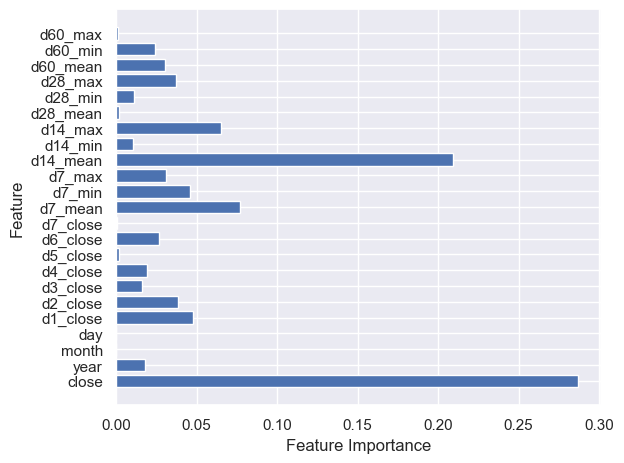

In [30]:
feature_importances = models[0].feature_importances_
plt.barh(range(len(feature_importances)), feature_importances)
plt.yticks(range(len(feature_importances)), [f'{i}' for i in abt_prev1.drop(columns=['next_close']).columns])  # ajuste conforme seus nomes de feature
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## 5. Avaliação

Vamos avaliar os modelos na base de teste.

### 5.1 Baseline

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:00<00:00, 303.14it/s]


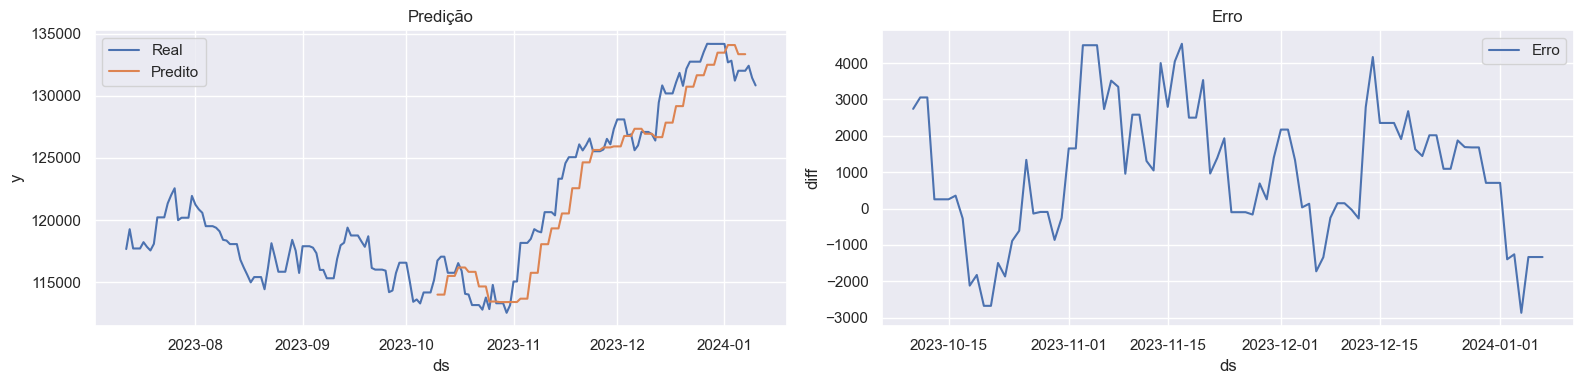

,MAE,RMSE,MAPE
Modelo,,,
Baseline - Teste,1658.106337,2059.29637,0.013418


In [31]:
df_test_baseline = dfs[0]['test'].copy()
df_test_baseline['unique_id'] = 1

model_baseline = StatsForecast(
    models=[WindowAverage(window_size=7)],
    freq='D',
    n_jobs=-1
)

indexes = get_sliding_window_index(df_test_baseline, window_train = 90, h = 3, plot = False)
df_pred = pd.DataFrame(columns=['ds', 'y_pred'])

for index in tqdm(indexes):
    df_test = df_test_baseline[index[0]:index[1]]

    model_baseline.fit(df_test)
    predict = model_baseline.predict(h=3)

    predict.rename(columns={'WindowAverage': 'y_pred'}, inplace=True)
    if df_pred.shape[0] == 0:
        df_pred = predict.reset_index()[['ds', 'y_pred']]
    else:
        df_pred = pd.concat([df_pred, predict.reset_index()[['ds', 'y_pred']]], axis=0)

result = df_pred.merge(df_test_baseline, on=['ds'], how='right')
result['diff'] = result['y'] - result['y_pred']

print_result(result, model = 'Baseline - Teste')

### 5.2 SARIMA

100%|██████████| 20/20 [00:03<00:00,  6.18it/s]


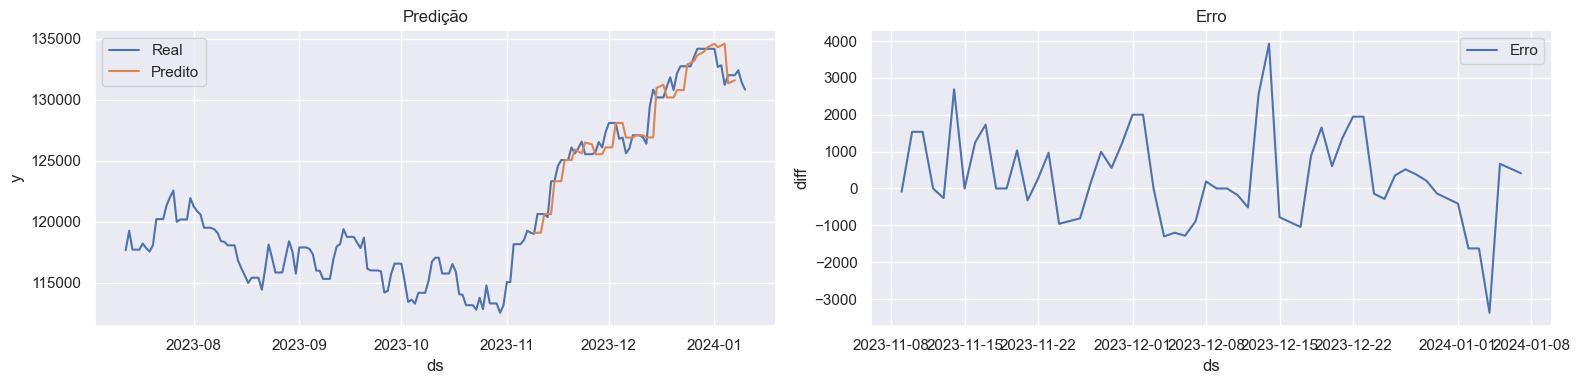

,MAE,RMSE,MAPE
Modelo,,,
SARIMA - Teste,923.647689,1253.313677,0.007187


In [39]:
df_test_arima = dfs[0]['test'].copy()

indexes = get_sliding_window_index(df_test_arima, window_train = 120, h = 3, plot = False)
df_pred = pd.DataFrame(columns=['ds', 'y_pred'])

for index in tqdm(indexes):
    df_test = df_test_arima[index[0]:index[1]]

    model_arima = auto_arima(
        df_test['y'],
        seasonal=True,
        trace=False,
        error_action='ignore',
        suppress_warnings=True,
    )
    predict = model_arima.predict(n_periods=3)
    
    predict_temp = pd.DataFrame(predict, columns=['y_pred'])
    predict_temp['ds'] = df_test_arima[index[2]:index[3]]['ds']

    if df_pred.shape[0] == 0:
        df_pred = predict_temp[['ds', 'y_pred']]
    else:
        df_pred = pd.concat([df_pred, predict_temp[['ds', 'y_pred']]], axis=0)

result = df_pred.merge(df_test_arima, on=['ds'], how='right')
result['diff'] = result['y'] - result['y_pred']

print_result(result, model = 'SARIMA - Teste')

### 5.3 XGBoost

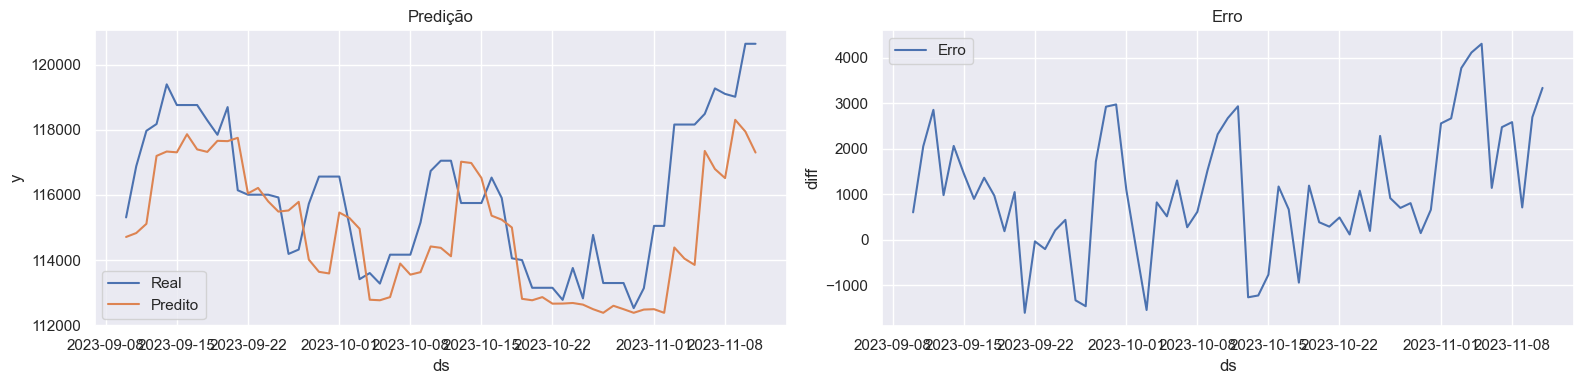

,MAE,RMSE,MAPE
Modelo,,,
XGB - Teste,1408.53063,1759.872611,0.012061


In [43]:
df_prev = pd.DataFrame(columns=['ds', 'y_pred'])

for start, end in zip(range(0, len(dfs[0]['test'])-120, 3), range(120, len(dfs[0]['test']), 3)):
    prev_data = create_abt(dfs[0]['test'][start:end])

    res_1 = models[0].predict(prev_data.drop(columns=['next_close']))
    data_res1 = (prev_data['year'].astype(str) + '-' + prev_data['month'].astype(str) + '-' + prev_data['day'].astype(str)).values[0]
    data_res1 = datetime.datetime.strptime(data_res1, '%Y-%m-%d') + datetime.timedelta(days=1)

    res_2 = models[1].predict(prev_data.drop(columns=['next_close']))
    data_res2 = (prev_data['year'].astype(str) + '-' + prev_data['month'].astype(str) + '-' + prev_data['day'].astype(str)).values[0]
    data_res2 = datetime.datetime.strptime(data_res2, '%Y-%m-%d') + datetime.timedelta(days=2)

    res_3 = models[2].predict(prev_data.drop(columns=['next_close']))
    data_res3 = (prev_data['year'].astype(str) + '-' + prev_data['month'].astype(str) + '-' + prev_data['day'].astype(str)).values[0]
    data_res3 = datetime.datetime.strptime(data_res3, '%Y-%m-%d') + datetime.timedelta(days=3)

    pred = pd.DataFrame({
        'ds': [data_res1, data_res2, data_res3],
        'y_pred': [res_1[0], res_2[0], res_3[0]]
    })

    if df_prev.shape[0] == 0:
        df_prev = pred
    else:
        df_prev = pd.concat([df_prev, pred], axis=0)

df_prev['ds'] = pd.to_datetime(df_prev['ds'])

result = dfs[0]['test'].merge(df_prev, on=['ds'], how='left').dropna()
result['diff'] = result['y'] - result['y_pred']
print_result(result, model = 'XGB - Teste')

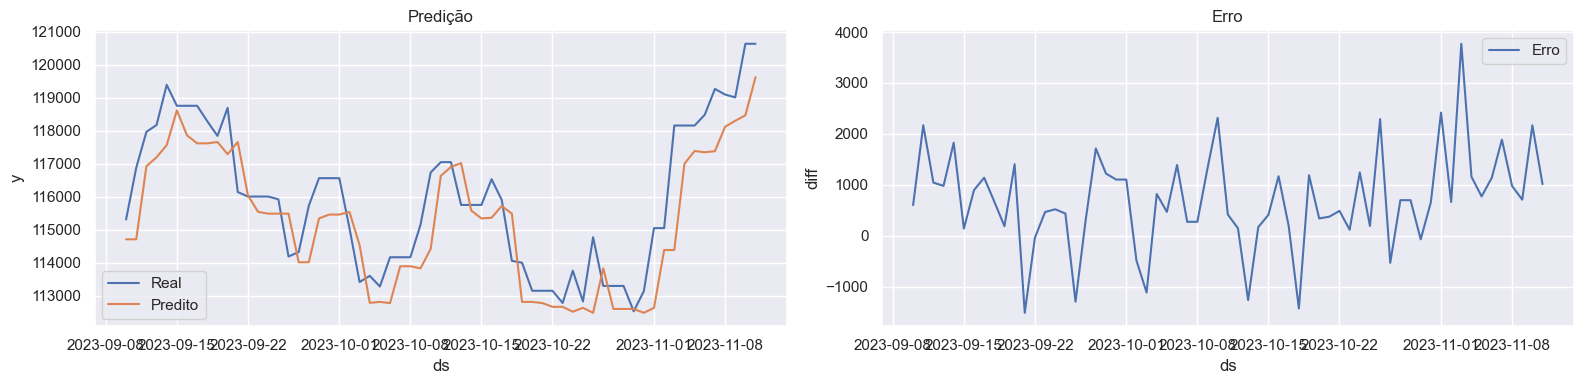

,MAE,RMSE,MAPE
Modelo,,,
XGB - Teste (1 dia),951.481895,1184.985397,0.008171


In [44]:
df_prev = pd.DataFrame(columns=['ds', 'y_pred'])

for start, end in zip(range(0, len(dfs[0]['test'])-120, 1), range(120, len(dfs[0]['test']), 1)):
    prev_data = create_abt(dfs[0]['test'][start:end])

    res_1 = models[0].predict(prev_data.drop(columns=['next_close']))
    data_res1 = (prev_data['year'].astype(str) + '-' + prev_data['month'].astype(str) + '-' + prev_data['day'].astype(str)).values[0]
    data_res1 = datetime.datetime.strptime(data_res1, '%Y-%m-%d') + datetime.timedelta(days=1)

    pred = pd.DataFrame({
        'ds': [data_res1],
        'y_pred': [res_1[0]]
    })

    if df_prev.shape[0] == 0:
        df_prev = pred
    else:
        df_prev = pd.concat([df_prev, pred], axis=0)

df_prev['ds'] = pd.to_datetime(df_prev['ds'])

result = dfs[0]['test'].merge(df_prev, on=['ds'], how='left').dropna()
result['diff'] = result['y'] - result['y_pred']
print_result(result, model = 'XGB - Teste (1 dia)')

## 6. Implantação

- Deploy do Modelo

In [6]:
df_raw

date,open,high,low,close
date,f64,f64,f64,f64
2023-01-02,109734.0,109734.0,105981.0,106376.0
2023-01-03,106377.0,106684.0,103852.0,104166.0
2023-01-04,104167.0,105627.0,103915.0,105334.0
2023-01-05,105336.0,107743.0,105333.0,107518.0
2023-01-06,107642.0,109433.0,107642.0,108836.0
2023-01-09,108964.0,109938.0,108134.0,109227.0
2023-01-10,109129.0,111193.0,108478.0,110912.0
2023-01-11,110816.0,111841.0,110752.0,111763.0
2023-01-12,112516.0,113129.0,110982.0,111877.0


In [17]:
df = (
    df_raw
    .filter(
        (pl.col('date') >= datetime.date(2023, 10, 2)) & (pl.col('date') <= datetime.date(2023, 12, 28))
    )
    .to_pandas()
)
df = df[['date', 'close']]
df.rename(columns={'close': 'y', 'date': 'ds'}, inplace=True)

pd_last_date = pd.DataFrame({'ds': ['31-12-2023'], 'y': [None]})
df = pd.concat([df, pd_last_date], ignore_index=True, axis=0)

df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values(by=['ds'])
        
df.set_index('ds', inplace=True)
df = df.asfreq('D')
df = df.ffill()

/var/folders/6x/3y02z1591rj130ytmr_hv8nh0000gn/T/ipykernel_54209/2872261757.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd_last_date], ignore_index=True, axis=0)


In [19]:
model_arima = auto_arima(
            df,
            seasonal=True,
            trace=False,
            error_action='ignore',
            suppress_warnings=True,
        )
predict = model_arima.predict(n_periods=3)

In [20]:
predict

2024-01-01    134439.448722
2024-01-02    134683.986907
2024-01-03    134928.911099
Freq: D, dtype: float64